# Testing conditional valid metrics for locart in new simulated settings and with new models

Here we will test conformal methods in different data settings and models to analyse why locart is having a worse perfomance than the other conformal methods in real data

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats as st

# base models and graph tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# conformal methods
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from lcv.locart import LocalRegressionSplit, LocartSplit, MondrianRegressionSplit, QuantileSplit
from lcv.locart import LocartSplit, MondrianRegressionSplit
from lcv.locluster import KmeansSplit
from lcv.scores import RegressionScore, QuantileScore, LocalRegressionScore

# importing LCP-RF
from acpi import ACPI

# simulation and performance measures
import time
from lcv.simulation import simulation
from lcv.utils import compute_interval_length, ILS_coverage, split, real_coverage, smis, wsc_coverage
from lcv.valid_pred_sets import Valid_pred_sets

original_path = os.getcwd()

# figure path
images_dir = "figures"

## Default testing metrics function:

In [2]:
def testing_metrics_sim(
    n = 25000,
    kind = "homoscedastic",
    d = 20,
    hetero_value = 1,
    asym_value = 0.6,
    t_degree = 4,
    base_model = RandomForestRegressor, 
    sig = 0.1, 
    test_size = 0.2,
    valid_test_size = 0.2,
    valid_split = True,
    valid_min_sample = 100,
    valid_prune = True,
    calib_size = 0.5, 
    coef = 2,
    noise = True,
    signif_vars = 3,
    B_x = 5000,
    B_y = 1000, 
    random_seed_X = 850,
    random_seed = 1250,
    random_projections = False,
    h = 20,
    m = 300,
    split_calib = True,
    plot_tree = True,
    plot_weighted_tree = True,
    mad_model_cte = False,
    nbins = 10,
    criterion = "squared_error",
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 150,
    prune = True,
    **kwargs):
    # generating X_test
    np.random.seed(random_seed_X)

    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, noise = noise, signif_vars = signif_vars, asym_value = asym_value, t_degree = t_degree)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    data = split(sim_obj.X, sim_obj.y, test_size = test_size, calib_size = calib_size, calibrate = True, random_seed = random_seed)
    r_kind = getattr(sim_obj, kind + "_r")
    if noise:
        y_mat = r_kind(X_test[:, 0], B = B_y)
    else:
        y_mat = r_kind(X_test, B = B_y)
        

    # fitting normal locart
    print("Fitting deafult locart to toy example:")
    start_loc = time.time()
    locart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "CART", base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune, random_projections = random_projections, 
    m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    locart_pred = np.array(locart_obj.predict(data["X_test"]))
    locart_pred_cond = np.array(locart_obj.predict(X_test))
    cond_locart_real = real_coverage(locart_pred_cond, y_mat)

    # average, median and max distance
    dif_locart = np.abs(cond_locart_real - (1 - sig))
    locart_ave_dist, locart_med_dist, locart_max_dist = np.mean(dif_locart), np.median(dif_locart), np.max(dif_locart)


    # valid pred sets
    locart_valid = Valid_pred_sets(conf = locart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    locart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_loc, max_set_dif_loc = locart_valid.compute_dif()

    # smis
    locart_smis = smis(locart_pred, data["y_test"], alpha = sig)

    # mean interval length
    locart_interval_len = np.mean(compute_interval_length(locart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
        data["y_test"] <= locart_pred[:, 1]) + 0
    locart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)

    # fitting normal RF-locart
    print("Fitting deafult RF-locart to toy example:")
    start_loc = time.time()
    rf_locart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "RF", base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    rf_locart_obj.fit(data["X_train"], data["y_train"])
    rf_locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune, random_projections = random_projections, 
    m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit RF-Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    rf_locart_pred = np.array(rf_locart_obj.predict(data["X_test"]))
    rf_locart_pred_cond = np.array(rf_locart_obj.predict(X_test))
    cond_rf_locart_real = real_coverage(rf_locart_pred_cond, y_mat)

    # average, median and max distance
    dif_rf_locart = np.abs(cond_rf_locart_real - (1 - sig))
    rf_locart_ave_dist, rf_locart_med_dist, rf_locart_max_dist = np.mean(dif_rf_locart), np.median(dif_rf_locart), np.max(dif_rf_locart)


    # valid pred sets
    rf_locart_valid = Valid_pred_sets(conf = rf_locart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    rf_locart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_rf_loc, max_set_dif_rf_loc = rf_locart_valid.compute_dif()

    # smis
    rf_locart_smis = smis(rf_locart_pred, data["y_test"], alpha = sig)

    # mean interval length
    rf_locart_interval_len = np.mean(compute_interval_length(rf_locart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= rf_locart_pred[:, 0], 
        data["y_test"] <= rf_locart_pred[:, 1]) + 0
    rf_locart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    rf_locart_interval_len_cover = np.mean(compute_interval_length(rf_locart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for RF-Locart: ", end_loc)


    # fitting normal difficulty locart
    print("Fitting difficulty locart to toy example:")
    start_loc = time.time()
    dlocart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "CART", base_model = base_model, alpha = sig, split_calib = split_calib, 
                              weighting = True,**kwargs)
    dlocart_obj.fit(data["X_train"], data["y_train"])
    dlocart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune, random_projections = random_projections, 
    m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    dlocart_pred = np.array(dlocart_obj.predict(data["X_test"]))
    dlocart_pred_cond = np.array(dlocart_obj.predict(X_test))
    cond_dlocart_real = real_coverage(dlocart_pred_cond, y_mat)

    # average, median and max distance
    dif_dlocart = np.abs(cond_dlocart_real - (1 - sig))
    dlocart_ave_dist, dlocart_med_dist, dlocart_max_dist = np.mean(dif_dlocart), np.median(dif_dlocart), np.max(dif_dlocart)


    # valid pred sets
    dlocart_valid = Valid_pred_sets(conf = dlocart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    dlocart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_dloc, max_set_dif_dloc = dlocart_valid.compute_dif()

    # smis
    dlocart_smis = smis(dlocart_pred, data["y_test"], alpha = sig)

    # mean interval length
    dlocart_interval_len = np.mean(compute_interval_length(dlocart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= dlocart_pred[:, 0], 
        data["y_test"] <= dlocart_pred[:, 1]) + 0
    dlocart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    dlocart_interval_len_cover = np.mean(compute_interval_length(dlocart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)


    # fitting RF difficulty locart
    print("Fitting difficulty RF-locart to toy example:")
    start_loc = time.time()
    rf_dlocart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "RF", base_model = base_model, alpha = sig, split_calib = split_calib, weighting = True, **kwargs)
    rf_dlocart_obj.fit(data["X_train"], data["y_train"])
    rf_dlocart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune, random_projections = random_projections, 
    m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    rf_dlocart_pred = np.array(rf_dlocart_obj.predict(data["X_test"]))
    rf_dlocart_pred_cond = np.array(rf_dlocart_obj.predict(X_test))
    cond_rf_dlocart_real = real_coverage(rf_dlocart_pred_cond, y_mat)

    # average, median and max distance
    dif_rf_dlocart = np.abs(cond_rf_dlocart_real - (1 - sig))
    rf_dlocart_ave_dist, rf_dlocart_med_dist, rf_dlocart_max_dist = np.mean(dif_rf_dlocart), np.median(dif_rf_dlocart), np.max(dif_rf_dlocart)


    # valid pred sets
    rf_dlocart_valid = Valid_pred_sets(conf = rf_dlocart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    rf_dlocart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_rf_dloc, max_set_dif_rf_dloc = rf_dlocart_valid.compute_dif()

    # smis
    rf_dlocart_smis = smis(rf_dlocart_pred, data["y_test"], alpha = sig)

    # mean interval length
    rf_dlocart_interval_len = np.mean(compute_interval_length(rf_dlocart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= rf_dlocart_pred[:, 0], 
        data["y_test"] <= rf_dlocart_pred[:, 1]) + 0
    rf_dlocart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    rf_dlocart_interval_len_cover = np.mean(compute_interval_length(rf_dlocart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for RF difficulty-Locart: ", end_loc)

    # fitting ACPI/LCP-RF
    print("Fitting LCP-RF to toy example:")
    start_loc = time.time()

    model = base_model(**kwargs)
    model.fit(data["X_train"], data["y_train"])
    acpi = ACPI(model_cali = model, n_estimators = 100, max_depth=20, min_node_size=10)
    acpi.fit(data["X_calib"], data["y_calib"], nonconformity_func = None)
    acpi.fit_calibration(data["X_calib"], data["y_calib"], quantile = 1 - sig, only_qrf = True)

    end_loc = time.time() - start_loc
    print("Time Elapsed to fit LCP-RF: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()

    acpi_pred = np.stack((acpi.predict_pi(data["X_test"], method = "qrf")), axis = -1)
    acpi_pred_cond = np.stack((acpi.predict_pi(X_test, method = "qrf")), axis = -1)
    cond_acpi_real = real_coverage(acpi_pred_cond, y_mat)

    # average, median and max distance
    dif_acpi = np.abs(cond_acpi_real - (1 - sig))
    acpi_ave_dist, acpi_med_dist, acpi_max_dist = np.mean(dif_acpi), np.median(dif_acpi), np.max(dif_acpi)

    # smis
    acpi_smis = smis(acpi_pred, data["y_test"], alpha = sig)

    # mean interval length
    acpi_interval_len = np.mean(compute_interval_length(acpi_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= acpi_pred[:, 0], 
        data["y_test"] <= acpi_pred[:, 1]) + 0
    acpi_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    acpi_interval_len_cover = np.mean(compute_interval_length(acpi_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for LCP-RF: ", end_loc)

    # fitting wlocart
    print("Fitting weighted RF-locart to toy example:")
    start_loc = time.time()

    wlocart_obj = LocartSplit(nc_score = LocalRegressionScore, cart_type = "RF", base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    wlocart_obj.fit(data["X_train"], data["y_train"], mad_model_cte = mad_model_cte)
    wlocart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune,
        random_projections = random_projections, m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    wlocart_pred = np.array(wlocart_obj.predict(data["X_test"]))
    wlocart_pred_cond = np.array(wlocart_obj.predict(X_test))
    cond_wlocart_real = real_coverage(wlocart_pred_cond, y_mat)

    # average, median and max distance
    dif_wlocart = np.abs(cond_wlocart_real - (1 - sig))
    wlocart_ave_dist, wlocart_med_dist, wlocart_max_dist = np.mean(dif_wlocart), np.median(dif_wlocart), np.max(dif_wlocart)


    # valid pred sets
    wlocart_valid = Valid_pred_sets(conf = wlocart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    wlocart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_wloc, max_set_dif_wloc = wlocart_valid.compute_dif()

    # smis
    wlocart_smis = smis(wlocart_pred, data["y_test"], alpha = sig)

    # mean interval length
    wlocart_interval_len = np.mean(compute_interval_length(wlocart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wlocart_pred[:, 0], 
        data["y_test"] <= wlocart_pred[:, 1]) + 0
    wlocart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wlocart_interval_len_cover = np.mean(compute_interval_length(wlocart_pred[cover_idx]))

    wloc_cutoffs = wlocart_obj.cutoffs

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)


    # fitting default regression split
    print("Fitting regression split")
    start_split = time.time()
    model = base_model(**kwargs)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_calib"], data["y_calib"])

    end_split = time.time() - start_split
    print("Time Elapsed to fit regression split: ", end_split)

    print("Computing metrics")
    start_split = time.time()
    # predictions
    icp_pred = icp.predict(data["X_test"], significance = sig)
    icp_pred_cond = icp.predict(X_test, significance = sig)
    cond_icp_real = real_coverage(icp_pred_cond, y_mat)
    
    # average, median and max distance
    dif_icp = np.abs(cond_icp_real - (1 - sig))
    icp_ave_dist, icp_med_dist, icp_max_dist = np.mean(dif_icp), np.median(dif_icp), np.max(dif_icp)

    # valid pred sets
    icp_valid = Valid_pred_sets(conf = icp, alpha = sig, isnc = True, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    icp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_icp, max_set_dif_icp = icp_valid.compute_dif()

    # icp smis
    icp_smis = smis(icp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    icp_interval_len = np.mean(compute_interval_length(icp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
        data["y_test"] <= icp_pred[:, 1]) + 0
    icp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

    end_split = time.time() - start_split
    print("Time Elapsed to compute statistics for regression split: ", end_split)

    # fitting wighted regression split
    print("Fitting weighted regression split")
    start_weighted_split = time.time()
    wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
    wicp.fit(data["X_train"], data["y_train"], mad_model_cte = mad_model_cte)
    wicp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    wicp_pred = wicp.predict(data["X_test"])
    wicp_pred_cond = wicp.predict(X_test)
    cond_wicp_real = real_coverage(wicp_pred_cond, y_mat)
    
    
    wicp_dif = np.abs(cond_wicp_real - (1 - sig))
    wicp_ave_dist, wicp_med_dist, wicp_max_dist = np.mean(wicp_dif), np.median(wicp_dif), np.max(wicp_dif)

    # valid pred sets
    wicp_valid = Valid_pred_sets(conf = wicp, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    wicp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_wicp , max_set_dif_wicp = wicp_valid.compute_dif()

    # smis
    wicp_smis = smis(wicp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
        data["y_test"] <= wicp_pred[:, 1]) + 0
    wicp_ave_marginal_cov = np.mean(
        marg_cover
    )

    wicp_cutoff = wicp.cutoff

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
    print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)

    # mondrian split
    print("Fitting mondrian regression split")
    start_weighted_split = time.time()
    micp = MondrianRegressionSplit(base_model, alpha = sig, k = nbins, **kwargs)
    micp.fit(data["X_train"], data["y_train"])
    micp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit mondrian regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    micp_pred = micp.predict(data["X_test"])
    micp_pred_cond = micp.predict(X_test)
    cond_micp_real = real_coverage(micp_pred_cond, y_mat)
    
    
    micp_dif = np.abs(cond_micp_real - (1 - sig))
    micp_ave_dist, micp_med_dist, micp_max_dist = np.mean(micp_dif), np.median(micp_dif), np.max(micp_dif)

    # valid pred sets
    micp_valid = Valid_pred_sets(conf = micp, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    micp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_micp, max_set_dif_micp = micp_valid.compute_dif()

    # smis
    micp_smis = smis(micp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    micp_interval_len = np.mean(compute_interval_length(micp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
        data["y_test"] <= micp_pred[:, 1]) + 0
    micp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))


    print("Cutoff points of wlocart: {}".format(wloc_cutoffs))
    print("Cutoff point of wicp: {}".format(wicp.cutoff))


    all_results =  pd.DataFrame(data = {"Methods":["LOCART", "RF-LOCART", "D-LOCART", "RF-D-LOCART", "LCP-RF", "Weighted LOCART", 
                                                   "Regresion split", "Weighted regression split", "Mondrian regression split"],
        "valid pred set":[pred_set_dif_loc, pred_set_dif_rf_loc, pred_set_dif_dloc, pred_set_dif_rf_dloc, 0, 
                          pred_set_dif_wloc, pred_set_dif_icp, pred_set_dif_wicp, pred_set_dif_micp],
        "smis":[locart_smis, rf_locart_smis, dlocart_smis, rf_dlocart_smis, acpi_smis, wlocart_smis, icp_smis, wicp_smis, micp_smis],
        "max pred set":[max_set_dif_loc, max_set_dif_rf_loc, max_set_dif_dloc, max_set_dif_rf_dloc, 
                        0, max_set_dif_wloc, max_set_dif_icp, max_set_dif_wicp, max_set_dif_micp],
        "Average marginal coverage":[locart_ave_marginal_cov, rf_locart_ave_marginal_cov, dlocart_ave_marginal_cov, rf_dlocart_ave_marginal_cov,
                                    acpi_ave_marginal_cov, wlocart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
        "Average interval length":[locart_interval_len, rf_locart_interval_len, dlocart_interval_len, rf_dlocart_interval_len,
                                   acpi_interval_len, wlocart_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
        "Average interval length given coverage":[locart_interval_len_cover, rf_locart_interval_len_cover, dlocart_interval_len_cover, rf_dlocart_interval_len_cover,
        acpi_interval_len_cover, wlocart_interval_len_cover, icp_interval_len_cover, wicp_interval_len_cover, micp_interval_len_cover],
        "Average distance":[locart_ave_dist, rf_locart_ave_dist, dlocart_ave_dist, rf_dlocart_ave_dist, 
                            acpi_ave_dist, wlocart_ave_dist, icp_ave_dist, wicp_ave_dist, micp_ave_dist],
        "Median distance":[locart_med_dist, rf_locart_med_dist, dlocart_med_dist, rf_dlocart_med_dist,
                            acpi_med_dist, wlocart_med_dist, icp_med_dist, wicp_med_dist, micp_med_dist],
        "Max distance":[locart_max_dist, rf_locart_max_dist, dlocart_max_dist, rf_dlocart_max_dist,
                         acpi_max_dist, wlocart_max_dist, icp_max_dist, wicp_max_dist, micp_max_dist]})

    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.show()
    
    if plot_weighted_tree:
        plt.figure(figsize=(25, 20))
        wlocart_obj.plot_locart()
        plt.show()

    return(all_results)

## Testing Random Forest locart with $p = 3$ and $d = 20$ and Random Forest base model:

In [3]:
homoc_metrics = testing_metrics_sim(random_seed = 950, random_state = 650, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = False, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150, 
                    plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  24.29012703895569
Computing metrics
Time Elapsed to compute metrics for Locart:  1.0665035247802734
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  36.34293460845947
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  1.4176549911499023
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  24.85979986190796
Computing metrics
Time Elapsed to compute metrics for Locart:  1.6375455856323242
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  37.514164209365845
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  2.1226062774658203
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [07:20<00:00,  8.82s/it]


Time Elapsed to fit LCP-RF:  485.141991853714
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  0.9287967681884766
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  69.22589206695557
Computing metrics
Time Elapsed to compute metrics for Locart:  1.2731165885925293
Fitting regression split
Time Elapsed to fit regression split:  18.736722469329834
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6435794830322266
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  58.87026381492615
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  58.87026381492615
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  24.7310528755188
Computing metrics
Cutoff points of wlocart: [{7: 5.443011099137084, 8: 4.435108434356667, 11: 5.27263203130384, 12: 6.604786972259554, 14: 5.657196723527342, 16: 4.7421017744233245, 17: 6.057783482258579, 18: 6.295778747

In [4]:
homoc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04640,-4.158116,0.100000,0.9058,3.372841,3.372841,0.011515,0.009,0.125
1,RF-LOCART,0.04812,-4.161993,0.116814,0.9030,3.350516,3.351550,0.013303,0.010,0.135
2,D-LOCART,0.04640,-4.158116,0.100000,0.9058,3.372841,3.372841,0.011515,0.009,0.125
3,RF-D-LOCART,0.05324,-4.162209,0.140000,0.9038,3.350695,3.351698,0.013156,0.010,0.137
4,LCP-RF,0.00000,-4.248702,0.000000,0.9010,3.388544,3.407070,0.033167,0.028,0.175
5,Weighted LOCART,0.04992,-4.248257,0.124880,0.9062,3.451120,3.471020,0.035214,0.030,0.199
6,Regresion split,0.04640,-4.158139,0.100000,0.9058,3.373234,3.373234,0.011517,0.009,0.125
7,Weighted regression split,0.05036,-4.254400,0.136641,0.9068,3.478703,3.499358,0.036112,0.031,0.219
8,Mondrian regression split,0.04788,-4.196410,0.106081,0.9046,3.386891,3.394603,0.023698,0.020,0.151


In [5]:
heteroc_metrics = testing_metrics_sim(kind = "heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650,
                                    valid_test_size=0.5, nbins = 30, noise = False, split_calib = False, valid_split = False, valid_prune = True, 
                                    valid_min_sample = 150, min_samples_leaf = 150, plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  26.96723222732544
Computing metrics
Time Elapsed to compute metrics for Locart:  1.3015596866607666
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  39.749905824661255
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  1.6894409656524658
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  26.29736042022705
Computing metrics
Time Elapsed to compute metrics for Locart:  1.81369948387146
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  37.61517882347107
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  2.4060747623443604
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [08:30<00:00, 10.22s/it]


Time Elapsed to fit LCP-RF:  567.9580950737
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  0.9973921775817871
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  74.8801257610321
Computing metrics
Time Elapsed to compute metrics for Locart:  2.261974573135376
Fitting regression split
Time Elapsed to fit regression split:  25.55637264251709
Computing metrics
Time Elapsed to compute statistics for regression split:  1.3714497089385986
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  59.89306831359863
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  59.89306831359863
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  23.50334668159485
Computing metrics
Cutoff points of wlocart: [{4: 5.4511191173593305, 6: 5.060963769059281, 7: 5.474343636575651, 10: 4.712668742082099, 11: 5.06959636728682, 15: 5.875357862127052, 16: 5.664850071540488, 18: 5.60459932444558

In [6]:
heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05148,-4.416355,0.153456,0.8956,3.393932,3.406039,0.055545,0.049,0.301
1,RF-LOCART,0.05148,-4.292088,0.097183,0.9020,3.365122,3.353292,0.040195,0.036,0.190
2,D-LOCART,0.04636,-4.334200,0.135294,0.9038,3.381284,3.384808,0.046111,0.041,0.257
3,RF-D-LOCART,0.04300,-4.317972,0.137288,0.9020,3.350519,3.353225,0.043153,0.037,0.265
4,LCP-RF,0.00000,-4.472416,0.000000,0.9048,3.467800,3.472654,0.060495,0.057,0.300
5,Weighted LOCART,0.05168,-4.341076,0.160000,0.9008,3.434016,3.450426,0.050239,0.044,0.263
6,Regresion split,0.06332,-4.550712,0.170000,0.8980,3.434371,3.434371,0.069063,0.067,0.291
7,Weighted regression split,0.05364,-4.347888,0.140310,0.8998,3.443512,3.457290,0.051282,0.046,0.271
8,Mondrian regression split,0.05108,-4.335960,0.111180,0.8952,3.315421,3.325152,0.048835,0.041,0.281


In [7]:
asym_metrics = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, asym_value = 0.6, valid_test_size=0.5, nbins = 30, 
                                   noise = False,   split_calib = False, valid_min_sample = 150, min_samples_leaf = 150, 
                                   plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  29.538546562194824
Computing metrics
Time Elapsed to compute metrics for Locart:  0.8854138851165771
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  41.39137411117554
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  1.356820821762085
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  30.076571464538574
Computing metrics
Time Elapsed to compute metrics for Locart:  1.5738458633422852
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  40.36721086502075
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  2.029278039932251
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [06:27<00:00,  7.76s/it]


Time Elapsed to fit LCP-RF:  437.77809405326843
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  0.8942210674285889
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  83.48859930038452
Computing metrics
Time Elapsed to compute metrics for Locart:  1.9260985851287842
Fitting regression split
Time Elapsed to fit regression split:  26.702677249908447
Computing metrics
Time Elapsed to compute statistics for regression split:  0.9026780128479004
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  68.34073209762573
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  68.34073209762573
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  26.612370014190674
Computing metrics
Cutoff points of wlocart: [{6: 4.454671635149226, 8: 4.149560996383542, 9: 4.159296293519326, 10: 5.06745278831732, 12: 5.185374883798232, 14: 5.7606224201419876, 15: 4.625396023038395, 17: 4.144447

In [8]:
asym_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.055759,-6.661112,0.166667,0.8978,4.194601,4.194601,0.051264,0.040,0.670
1,RF-LOCART,0.043535,-6.496781,0.131788,0.9044,4.142681,4.133231,0.037686,0.029,0.621
2,D-LOCART,0.045862,-6.513588,0.101183,0.9038,4.040399,4.041979,0.040964,0.033,0.509
3,RF-D-LOCART,0.052275,-6.496689,0.105556,0.9034,4.050536,4.045746,0.037985,0.032,0.581
4,LCP-RF,0.000000,-6.676030,0.000000,0.9062,4.378977,4.396604,0.049172,0.040,0.613
5,Weighted LOCART,0.047472,-6.547805,0.093590,0.9030,4.173446,4.196451,0.043524,0.036,0.485
6,Regresion split,0.055759,-6.661107,0.166667,0.8978,4.194824,4.194824,0.051259,0.040,0.670
7,Weighted regression split,0.049606,-6.566438,0.173333,0.8990,4.145284,4.173604,0.045452,0.038,0.420
8,Mondrian regression split,0.054903,-6.561430,0.130392,0.8984,4.023438,4.029078,0.045320,0.037,0.520


In [9]:
asym_metrics_v2 = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, asym_value = 1.5, valid_test_size=0.5, nbins = 30, 
                                      noise = False,   split_calib = False, valid_min_sample = 150, min_samples_leaf = 150, 
                                   plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  28.968565464019775
Computing metrics
Time Elapsed to compute metrics for Locart:  0.8335232734680176
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  41.467318058013916
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  1.3029067516326904
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  31.01711678504944
Computing metrics
Time Elapsed to compute metrics for Locart:  1.443965196609497
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  42.275059938430786
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  2.055269479751587
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [07:22<00:00,  8.84s/it]


Time Elapsed to fit LCP-RF:  498.42954206466675
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  0.9823563098907471
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  74.0902726650238
Computing metrics
Time Elapsed to compute metrics for Locart:  1.063368558883667
Fitting regression split
Time Elapsed to fit regression split:  29.869274854660034
Computing metrics
Time Elapsed to compute statistics for regression split:  0.8583791255950928
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  64.46135234832764
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  64.46135234832764
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  29.753215312957764
Computing metrics
Cutoff points of wlocart: [{3: 5.0217684444239765, 5: 4.954169071869248, 6: 4.66114488194232, 11: 4.935803338247544, 14: 5.5227245935496985, 15: 4.409230274677779, 16: 4.5177434726766945, 20: 4.702639

In [10]:
asym_metrics_v2

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.047650,-10.023599,0.115962,0.8950,6.575579,6.609935,0.066663,0.052,0.693
1,RF-LOCART,0.044516,-9.618214,0.100000,0.9148,6.612971,6.575463,0.045900,0.040,0.646
2,D-LOCART,0.050734,-9.731789,0.100000,0.9034,6.327962,6.347238,0.053897,0.048,0.453
3,RF-D-LOCART,0.047561,-9.638724,0.089349,0.9082,6.299606,6.298574,0.049156,0.044,0.434
4,LCP-RF,0.000000,-10.133619,0.000000,0.9136,7.122069,7.111591,0.061460,0.057,0.649
5,Weighted LOCART,0.047307,-9.660740,0.119512,0.9048,6.513306,6.553822,0.051260,0.045,0.348
6,Regresion split,0.054312,-10.714973,0.129299,0.9036,7.099704,7.099704,0.080460,0.069,0.711
7,Weighted regression split,0.049285,-9.691890,0.091336,0.9026,6.451398,6.483677,0.052930,0.046,0.348
8,Mondrian regression split,0.049783,-9.701641,0.082796,0.8972,6.123849,6.162158,0.056985,0.047,0.391


In [11]:
non_cor_heteroc = testing_metrics_sim(kind = "non_cor_heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650,
                                      noise = False, valid_test_size = 0.5, nbins = 30, split_calib = False, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 150, plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  42.70650029182434
Computing metrics
Time Elapsed to compute metrics for Locart:  1.1090972423553467
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  42.51669096946716
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  1.3087668418884277
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  35.03418588638306
Computing metrics
Time Elapsed to compute metrics for Locart:  0.9473531246185303
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  42.1007194519043
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  2.2456953525543213
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [07:05<00:00,  8.50s/it]


Time Elapsed to fit LCP-RF:  485.8338532447815
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  0.9186334609985352
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  75.20180106163025
Computing metrics
Time Elapsed to compute metrics for Locart:  1.0816993713378906
Fitting regression split
Time Elapsed to fit regression split:  32.33739161491394
Computing metrics
Time Elapsed to compute statistics for regression split:  1.2754192352294922
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  64.79852771759033
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  64.79852771759033
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  42.3041672706604
Computing metrics
Cutoff points of wlocart: [{4: 4.785125669467392, 7: 5.840152481512691, 10: 5.408688159036483, 11: 5.093694165349911, 12: 5.857932865417155, 15: 5.526782322393209, 17: 6.278387345757453, 20: 5.891806530

In [12]:
non_cor_heteroc

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04960,-4.312426,0.131638,0.8978,3.311175,3.319167,0.055622,0.049,0.246
1,RF-LOCART,0.05180,-4.226091,0.096653,0.9050,3.318024,3.305503,0.039856,0.035,0.156
2,D-LOCART,0.04956,-4.432953,0.127273,0.8998,3.389138,3.393880,0.064290,0.063,0.262
3,RF-D-LOCART,0.05088,-4.368754,0.186667,0.8986,3.350672,3.348076,0.057988,0.057,0.245
4,LCP-RF,0.00000,-4.414834,0.000000,0.9004,3.393143,3.401079,0.060720,0.058,0.260
5,Weighted LOCART,0.04840,-4.299122,0.150000,0.9000,3.385488,3.399149,0.049729,0.045,0.225
6,Regresion split,0.06292,-4.477126,0.181106,0.8974,3.390198,3.390198,0.068783,0.067,0.265
7,Weighted regression split,0.04616,-4.310919,0.161628,0.9038,3.386417,3.399150,0.051503,0.046,0.243
8,Mondrian regression split,0.05028,-4.457172,0.120532,0.8998,3.416681,3.427898,0.065414,0.062,0.315


## Testing Random Forest locart on KNN base model:

In [13]:
homoc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, n_neighbors = 30, 
                                    random_seed = 950, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = False,valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150, 
                    plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  46.1213915348053
Computing metrics
Time Elapsed to compute metrics for Locart:  9.651710748672485
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  26.734952211380005
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  6.553033113479614
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  28.360875129699707
Computing metrics
Time Elapsed to compute metrics for Locart:  6.1287312507629395
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  44.901923418045044
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  6.940258026123047
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [06:18<00:00,  7.57s/it]


Time Elapsed to fit LCP-RF:  410.87393140792847
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  3.8740127086639404
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  25.76390027999878
Computing metrics
Time Elapsed to compute metrics for Locart:  11.069683313369751
Fitting regression split
Time Elapsed to fit regression split:  3.4864587783813477
Computing metrics
Time Elapsed to compute statistics for regression split:  5.649138689041138
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  10.355472803115845
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  10.355472803115845
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  24.39293646812439
Computing metrics
Cutoff points of wlocart: [{1: 2.490249496147921, 4: 2.579313252896112, 7: 2.0699355403133906, 8: 2.088797378980762, 12: 2.3315907029587017, 13: 2.540679420167631, 18: 2.036798097146291, 19: 2.49922

In [14]:
homoc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05192,-4.522470,0.138739,0.9038,3.691090,3.691090,0.033065,0.028,0.333
1,RF-LOCART,0.04860,-4.512666,0.150000,0.8998,3.627033,3.627075,0.028672,0.022,0.278
2,D-LOCART,0.05192,-4.522470,0.138739,0.9038,3.691090,3.691090,0.033065,0.028,0.333
3,RF-D-LOCART,0.05076,-4.513248,0.107746,0.9000,3.627129,3.627170,0.028685,0.022,0.273
4,LCP-RF,0.00000,-4.604106,0.000000,0.9012,3.704538,3.720624,0.039117,0.032,0.397
5,Weighted LOCART,0.04772,-4.645214,0.129508,0.8998,3.726422,3.754640,0.047716,0.039,0.416
6,Regresion split,0.05192,-4.522481,0.138739,0.9038,3.691359,3.691359,0.033072,0.028,0.333
7,Weighted regression split,0.04928,-4.653176,0.148731,0.9018,3.756244,3.783794,0.048390,0.040,0.453
8,Mondrian regression split,0.05104,-4.540951,0.120000,0.8998,3.636644,3.641440,0.036561,0.028,0.341


In [15]:
heteroc_metrics = testing_metrics_sim(kind = "heteroscedastic", hetero_value = 0.25, base_model = KNeighborsRegressor, n_neighbors = 30, 
                                      random_seed = 950, valid_test_size=0.5, nbins = 30, noise = False, 
                                      split_calib = False, valid_split = False, valid_prune = True, 
                                    valid_min_sample = 150, min_samples_leaf = 150, plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  5.377660274505615
Computing metrics
Time Elapsed to compute metrics for Locart:  5.520101070404053
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  17.18879246711731
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  5.912932872772217
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  27.852938175201416
Computing metrics
Time Elapsed to compute metrics for Locart:  6.102867364883423
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  36.22198295593262
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  6.469555139541626
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [07:18<00:00,  8.76s/it]


Time Elapsed to fit LCP-RF:  468.35842084884644
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  3.5131542682647705
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  22.83653450012207
Computing metrics
Time Elapsed to compute metrics for Locart:  10.061512470245361
Fitting regression split
Time Elapsed to fit regression split:  3.1131198406219482
Computing metrics
Time Elapsed to compute statistics for regression split:  4.9865522384643555
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  10.483406066894531
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  10.483406066894531
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  22.888989210128784
Computing metrics
Cutoff points of wlocart: [{1: 2.5918427640740056, 4: 2.5294167560701752, 7: 2.939885399107856, 9: 1.9578621416321076, 10: 2.2622311911336066, 16: 2.7985817729895595, 17: 2.179667182469511, 21: 2.

In [16]:
heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05696,-4.716036,0.137179,0.8884,3.570302,3.583971,0.061168,0.052,0.380
1,RF-LOCART,0.05080,-4.596936,0.146753,0.9020,3.607511,3.586456,0.045671,0.040,0.228
2,D-LOCART,0.05000,-4.625481,0.129730,0.8950,3.604628,3.601180,0.051655,0.045,0.381
3,RF-D-LOCART,0.04932,-4.588455,0.137179,0.8950,3.581497,3.575826,0.048833,0.042,0.354
4,LCP-RF,0.00000,-4.844697,0.000000,0.9030,3.717494,3.720354,0.065795,0.064,0.330
5,Weighted LOCART,0.05292,-4.743686,0.133184,0.9032,3.716139,3.727933,0.059546,0.054,0.396
6,Regresion split,0.07312,-4.966281,0.281910,0.9000,3.730715,3.730715,0.077942,0.075,0.393
7,Weighted regression split,0.05536,-4.903441,0.181437,0.8974,3.733219,3.744298,0.072194,0.067,0.399
8,Mondrian regression split,0.05396,-4.656295,0.140000,0.8886,3.522612,3.531040,0.055230,0.046,0.335


In [17]:
asym_metrics = testing_metrics_sim(kind = "asymmetric", random_seed = 950, base_model = KNeighborsRegressor, n_neighbors = 30, 
                                   asym_value = 0.6, valid_test_size=0.5, nbins = 30, 
                                   noise = False, split_calib = False, valid_min_sample = 150, min_samples_leaf = 150, 
                                   plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  4.770970106124878
Computing metrics
Time Elapsed to compute metrics for Locart:  4.87691330909729
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  17.045183420181274
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  5.066508769989014
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  31.919622898101807
Computing metrics
Time Elapsed to compute metrics for Locart:  5.308706521987915
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  43.006996393203735
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  6.192317485809326
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [06:10<00:00,  7.41s/it]


Time Elapsed to fit LCP-RF:  399.0102071762085
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  2.7996625900268555
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  19.687883138656616
Computing metrics
Time Elapsed to compute metrics for Locart:  8.57077670097351
Fitting regression split
Time Elapsed to fit regression split:  3.325080394744873
Computing metrics
Time Elapsed to compute statistics for regression split:  4.918095827102661
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.647068500518799
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.647068500518799
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  29.701263904571533
Computing metrics
Cutoff points of wlocart: [{2: 2.5074606242775217, 6: 2.341353976928631, 7: 1.9848477442676895, 9: 2.025345137704096, 12: 2.15858915379713, 13: 1.7765442104877647, 14: 1.7221110807013282, 18: 2.02899515

In [18]:
asym_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.052007,-7.063493,0.090521,0.8910,4.250462,4.254711,0.050249,0.0410,0.438
1,RF-LOCART,0.047784,-6.975636,0.121198,0.9006,4.294858,4.278067,0.044364,0.0395,0.397
2,D-LOCART,0.054947,-7.030954,0.119048,0.8918,4.290462,4.289153,0.052512,0.0430,0.419
3,RF-D-LOCART,0.050531,-6.969487,0.120000,0.8952,4.319459,4.306094,0.046913,0.0410,0.445
4,LCP-RF,0.000000,-7.116171,0.000000,0.8972,4.454334,4.464336,0.055660,0.0470,0.425
5,Weighted LOCART,0.047672,-7.123801,0.132258,0.8952,4.363640,4.379946,0.050386,0.0430,0.418
6,Regresion split,0.052540,-7.244004,0.137374,0.8946,4.330983,4.330983,0.058208,0.0490,0.431
7,Weighted regression split,0.058507,-7.287492,0.127074,0.8924,4.331743,4.353254,0.056174,0.0460,0.502
8,Mondrian regression split,0.056319,-7.085172,0.146377,0.8918,4.322944,4.319671,0.054536,0.0450,0.469


In [19]:
asym_metrics_v2 = testing_metrics_sim(kind = "asymmetric", random_seed = 950, base_model = KNeighborsRegressor, n_neighbors = 30, 
                                   asym_value = 1.5, valid_test_size=0.5, nbins = 30, 
                                   noise = False, split_calib = False, valid_min_sample = 150, min_samples_leaf = 150, 
                                   plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  5.320894956588745
Computing metrics
Time Elapsed to compute metrics for Locart:  5.265307188034058
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  16.88067078590393
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  5.51058554649353
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  33.228862285614014
Computing metrics
Time Elapsed to compute metrics for Locart:  4.938800811767578
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  39.762938499450684
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  5.397870302200317
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [06:55<00:00,  8.32s/it]


Time Elapsed to fit LCP-RF:  441.29373478889465
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  3.918856382369995
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  25.682880878448486
Computing metrics
Time Elapsed to compute metrics for Locart:  10.158164501190186
Fitting regression split
Time Elapsed to fit regression split:  3.0937108993530273
Computing metrics
Time Elapsed to compute statistics for regression split:  4.958980083465576
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  10.239052772521973
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  10.239052772521973
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  30.844985723495483
Computing metrics
Cutoff points of wlocart: [{3: 3.6219367138686698, 5: 2.3896277491365434, 6: 1.5665463054205806, 9: 2.142981136700204, 11: 2.2996099876186036, 12: 1.8039486857614486, 16: 2.916404648368589, 17: 1.7

In [20]:
asym_metrics_v2

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.051497,-11.039865,0.133333,0.8972,7.238260,7.272243,0.070432,0.061,0.696
1,RF-LOCART,0.050468,-10.685012,0.103947,0.9198,7.271111,7.200425,0.055742,0.054,0.665
2,D-LOCART,0.050151,-10.946311,0.112121,0.9038,7.356986,7.369903,0.065223,0.057,0.634
3,RF-D-LOCART,0.054484,-10.762243,0.100000,0.9084,7.333016,7.320022,0.061240,0.054,0.619
4,LCP-RF,0.000000,-11.325415,0.000000,0.9050,7.286961,7.270547,0.074201,0.071,0.723
5,Weighted LOCART,0.049644,-10.961905,0.124599,0.9134,7.233350,7.223973,0.061744,0.058,0.453
6,Regresion split,0.066013,-12.121243,0.256383,0.9030,7.033948,7.033948,0.086504,0.078,0.578
7,Weighted regression split,0.065507,-11.792740,0.224468,0.9002,6.854424,6.849438,0.079327,0.071,0.596
8,Mondrian regression split,0.048509,-11.013220,0.120000,0.8940,7.237083,7.277544,0.070923,0.058,0.638


In [21]:
non_cor_heteroc = testing_metrics_sim(kind = "non_cor_heteroscedastic", hetero_value = 0.25, base_model = KNeighborsRegressor, n_neighbors = 30, 
                                      random_seed = 950, valid_test_size=0.5, nbins = 30, noise = False, 
                                      split_calib = False, valid_split = False, valid_prune = True, 
                                    valid_min_sample = 150, min_samples_leaf = 150, plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  4.796119689941406
Computing metrics
Time Elapsed to compute metrics for Locart:  5.190053701400757
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  16.16994833946228
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  5.738653659820557
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  46.13197565078735
Computing metrics
Time Elapsed to compute metrics for Locart:  5.763434886932373
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  56.31037902832031
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  6.0957653522491455
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [06:56<00:00,  8.32s/it]


Time Elapsed to fit LCP-RF:  443.33409237861633
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  3.134326457977295
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  22.801063060760498
Computing metrics
Time Elapsed to compute metrics for Locart:  10.005826473236084
Fitting regression split
Time Elapsed to fit regression split:  3.502131223678589
Computing metrics
Time Elapsed to compute statistics for regression split:  5.779785871505737
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  10.328979730606079
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  10.328979730606079
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  43.99207878112793
Computing metrics
Cutoff points of wlocart: [{5: 2.68120447634823, 6: 2.614524357990312, 8: 3.0470940749314863, 9: 2.990443040708162, 11: 2.3078837535653367, 13: 1.737829003644693, 14: 1.9632110731480419, 18: 2.307649

In [22]:
non_cor_heteroc

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05108,-4.357674,0.113333,0.8976,3.335403,3.344956,0.054587,0.048,0.251
1,RF-LOCART,0.05492,-4.279839,0.125131,0.9012,3.331766,3.319800,0.042333,0.038,0.149
2,D-LOCART,0.04772,-4.472882,0.136994,0.8948,3.376237,3.377883,0.064729,0.064,0.244
3,RF-D-LOCART,0.04604,-4.407861,0.131638,0.8980,3.346109,3.342856,0.057061,0.055,0.253
4,LCP-RF,0.00000,-4.474930,0.000000,0.9034,3.457584,3.464865,0.062097,0.061,0.271
5,Weighted LOCART,0.04724,-4.383079,0.140000,0.9012,3.429094,3.443238,0.053330,0.047,0.314
6,Regresion split,0.05616,-4.518353,0.169231,0.8932,3.391125,3.391125,0.068880,0.067,0.254
7,Weighted regression split,0.04760,-4.472771,0.120126,0.8984,3.447241,3.459245,0.061877,0.057,0.312
8,Mondrian regression split,0.05220,-4.522613,0.151366,0.8902,3.315002,3.328665,0.068344,0.065,0.278


## First using a random forest base model with default arguments in all data settings with $d = 20$ and $p = 3$ relevant variables:

Fitting locart to toy example:
Time Elapsed to fit Locart:  30.62750220298767
Computing metrics
Time Elapsed to compute metrics for Locart:  1.5735793113708496
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  68.91602683067322
Computing metrics
Time Elapsed to compute metrics for Locart:  2.2005481719970703
Fitting regression split
Time Elapsed to fit regression split:  23.22993779182434
Computing metrics
Time Elapsed to compute statistics for regression split:  1.10371994972229
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  61.940882205963135
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  61.940882205963135
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  23.98915672302246
Computing metrics
Cutoff points of wlocart: [5.51863128]
Cutoff point of wicp: 5.559231375760108


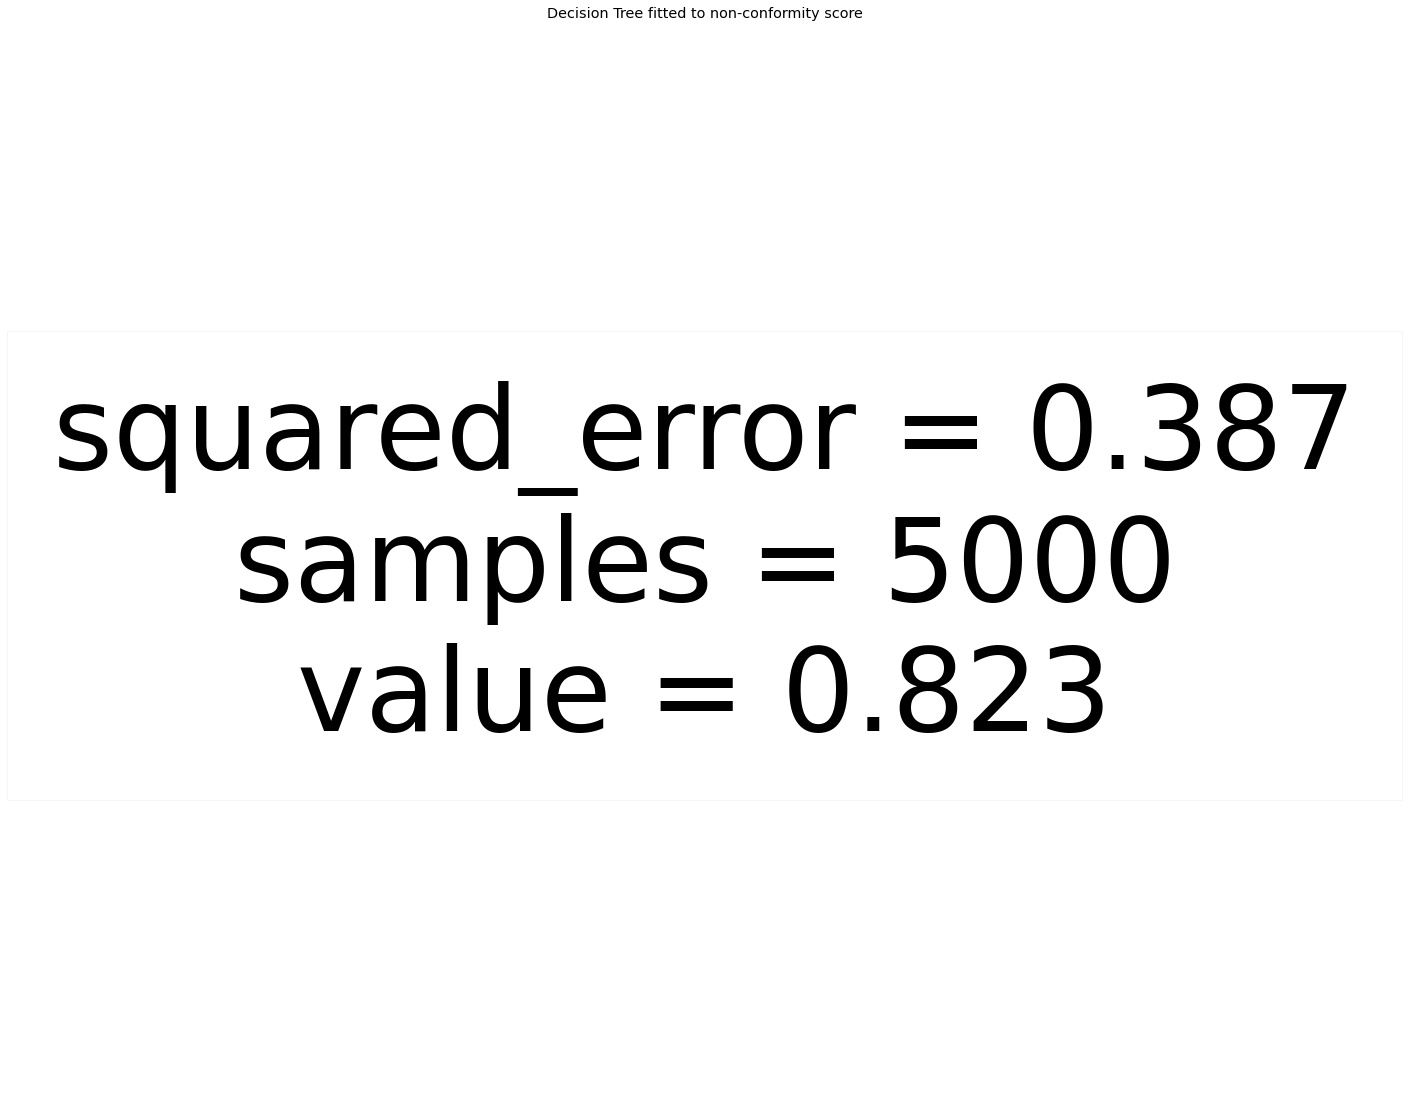

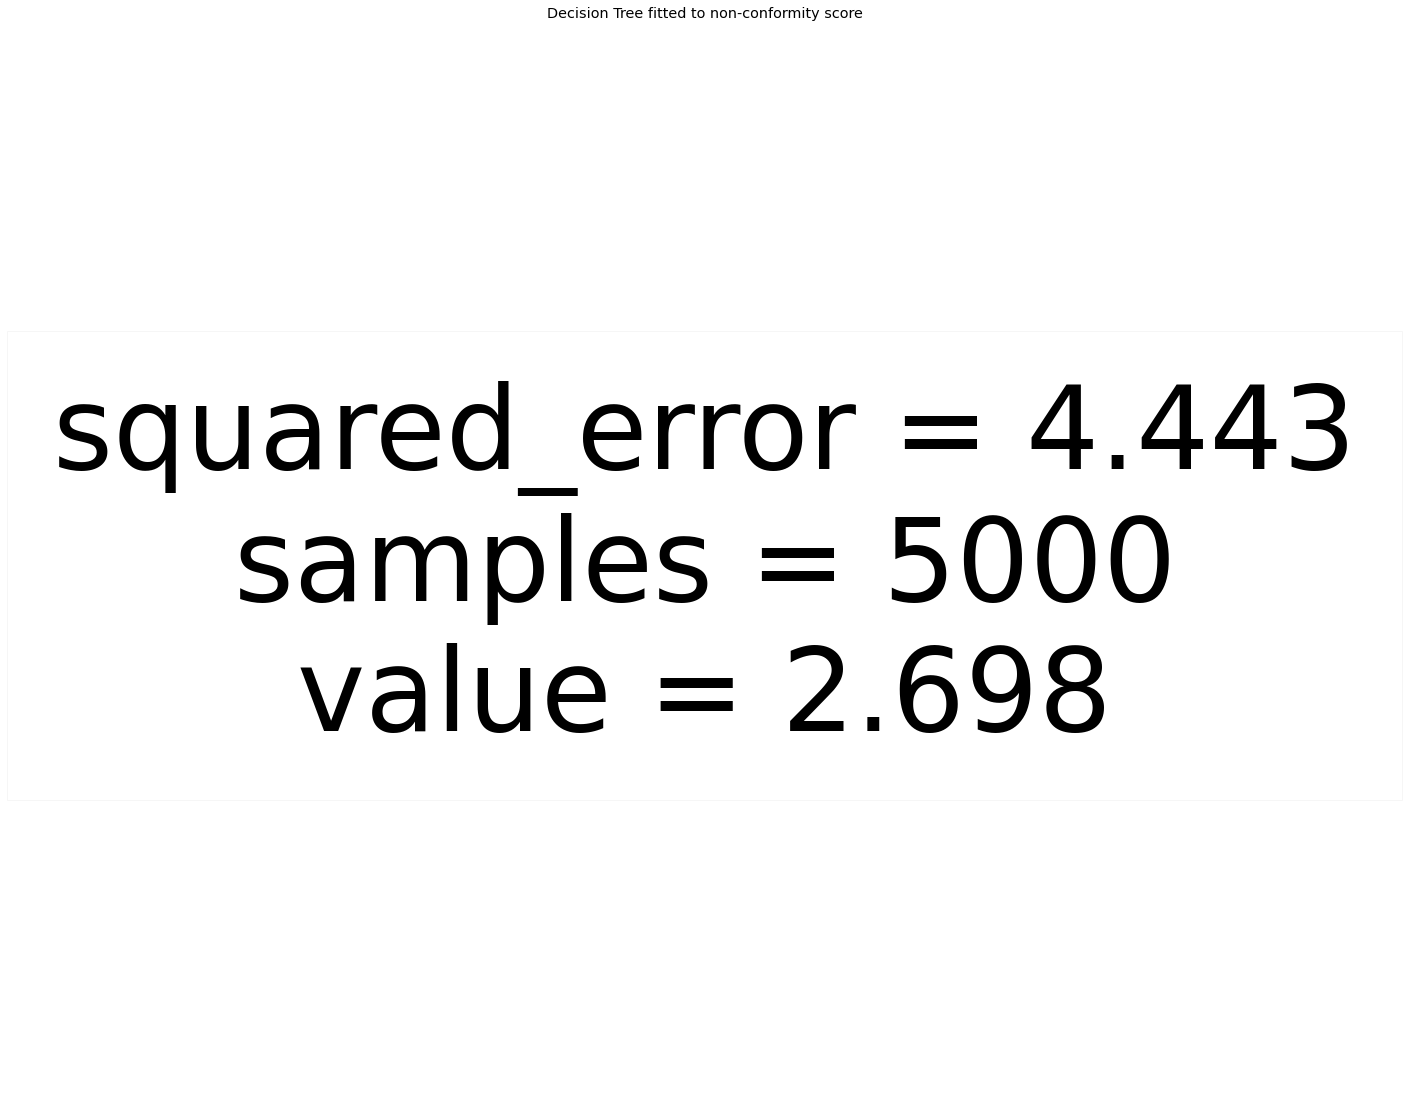

In [3]:
# homoscedastic data
homoc_metrics = testing_metrics_sim(random_seed = 950, random_state = 650, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [4]:
homoc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04404,-4.158279,0.094444,0.9066,3.375478,3.375478,0.011542,0.009,0.125
1,Weighted LOCART,0.04920,-4.251647,0.134615,0.9040,3.453297,3.474390,0.036356,0.031,0.223
2,Regresion split,0.04640,-4.158139,0.100000,0.9058,3.373234,3.373234,0.011517,0.009,0.125
3,Weighted regression split,0.05036,-4.254400,0.136641,0.9068,3.478703,3.499358,0.036112,0.031,0.219
4,Mondrian regression split,0.04788,-4.196410,0.106081,0.9046,3.386891,3.394603,0.023698,0.020,0.151


Fitting locart to toy example:
Time Elapsed to fit Locart:  30.864765405654907
Computing metrics
Time Elapsed to compute metrics for Locart:  1.6559576988220215
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  63.362555503845215
Computing metrics
Time Elapsed to compute metrics for Locart:  2.1954877376556396
Fitting regression split
Time Elapsed to fit regression split:  21.963252067565918
Computing metrics
Time Elapsed to compute statistics for regression split:  1.2485260963439941
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  49.307483434677124
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  49.307483434677124
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  20.225533485412598
Computing metrics
Cutoff points of wlocart: [5.48915238]
Cutoff point of wicp: 5.510769535483209


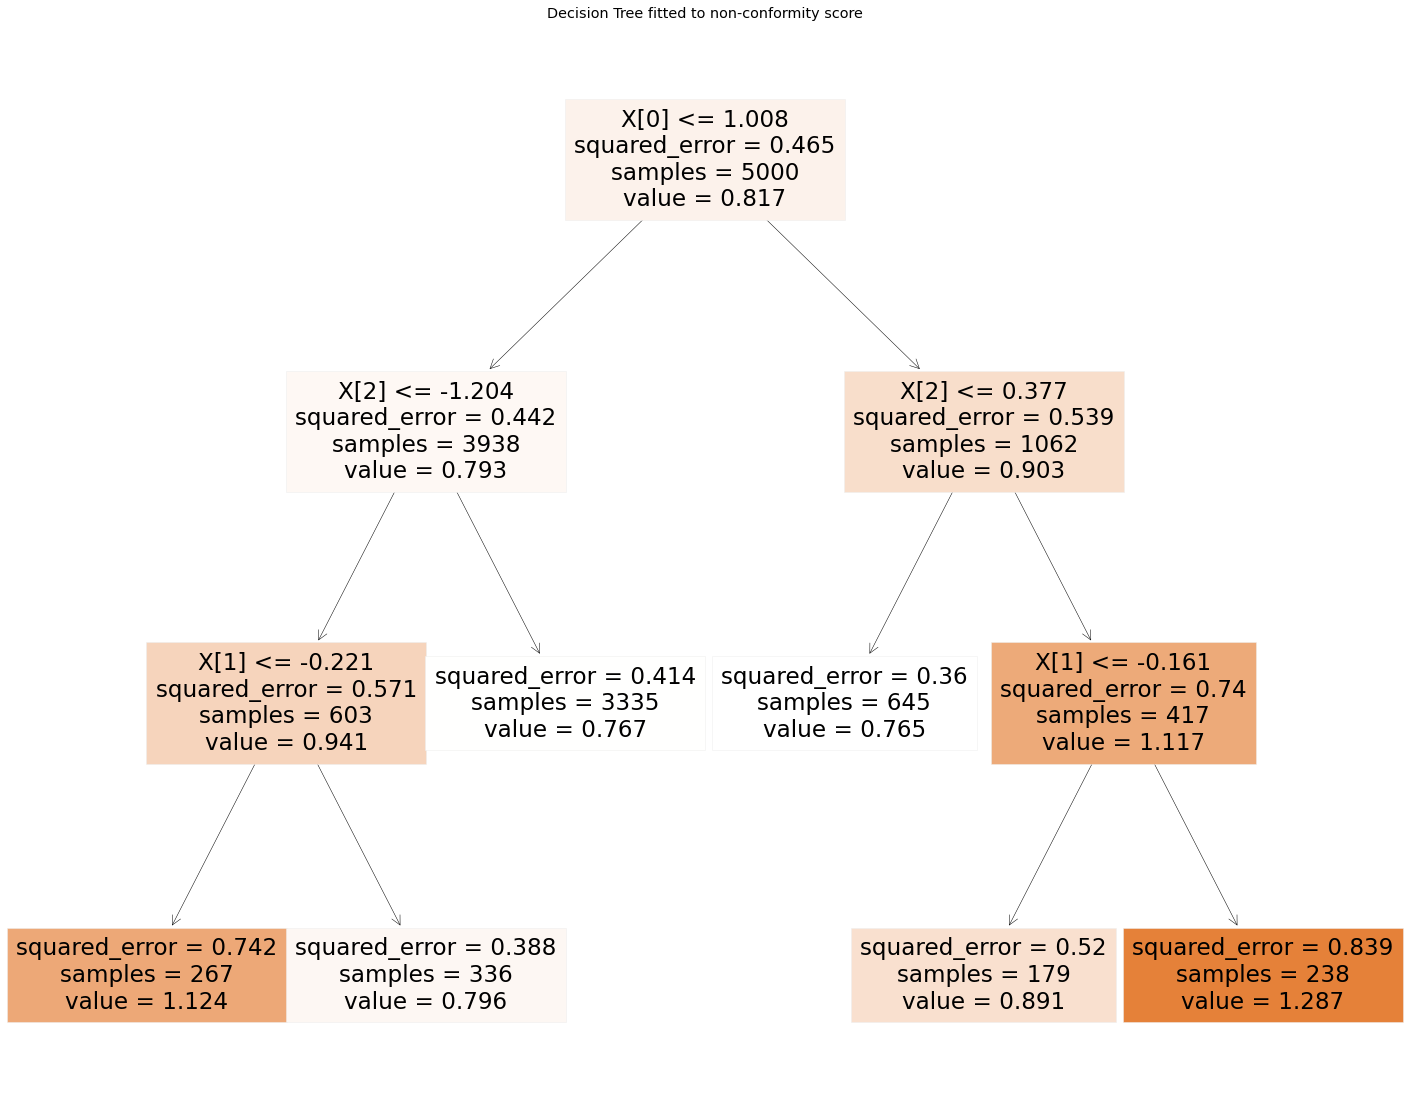

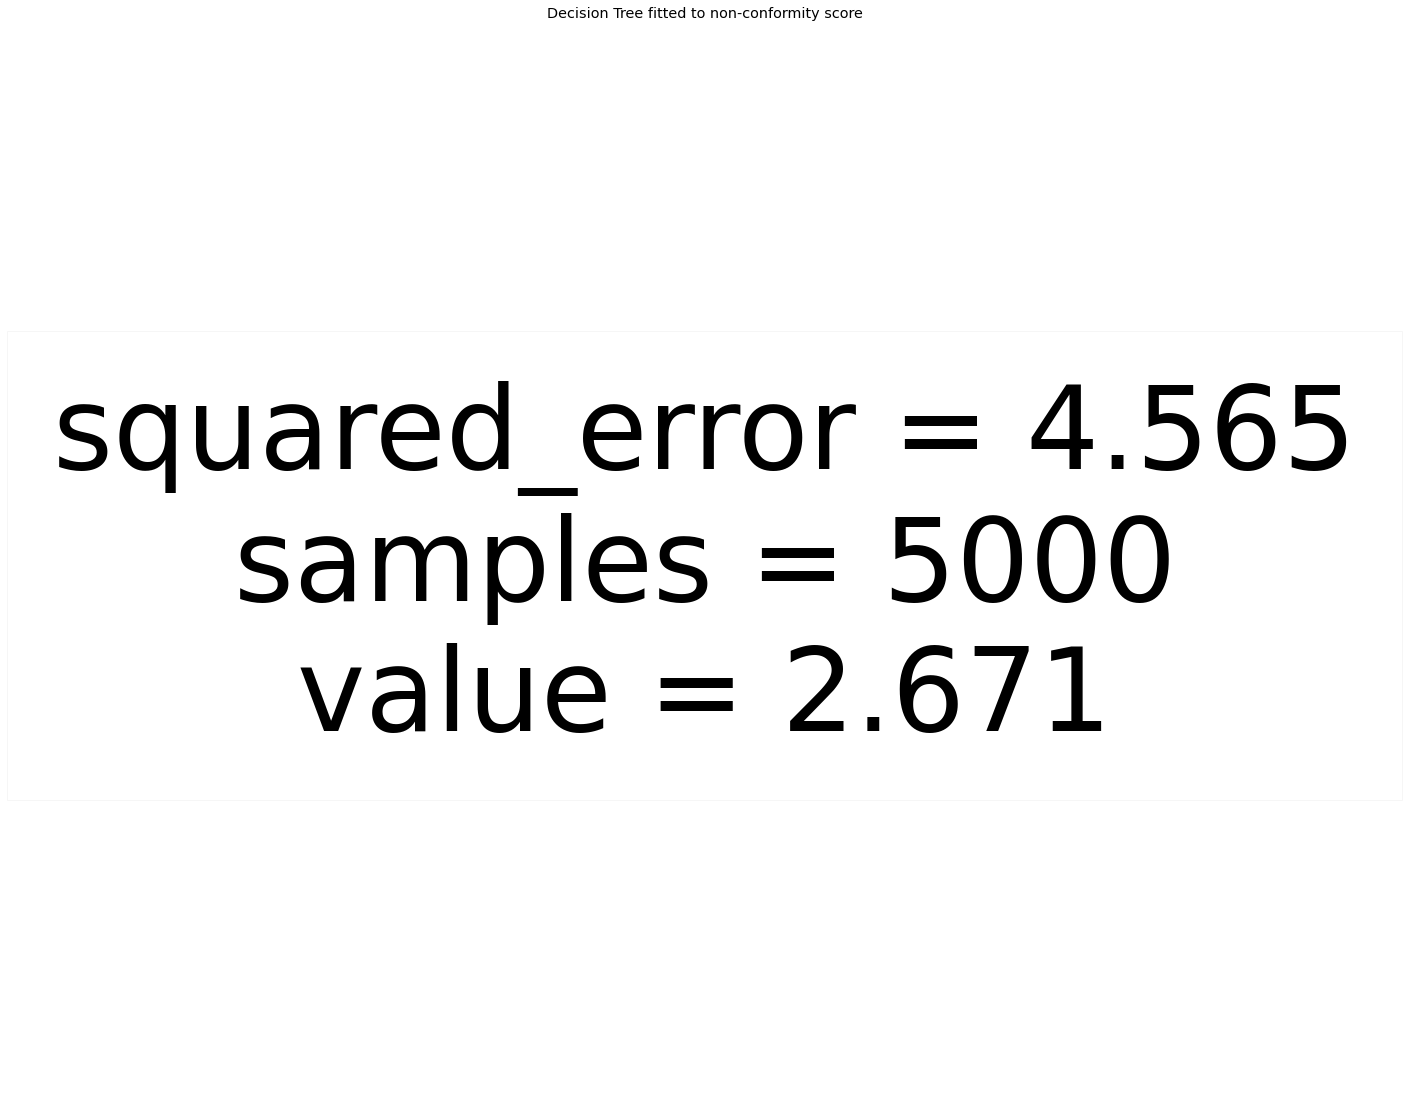

In [5]:
# heteroscedastic data
heteroc_metrics = testing_metrics_sim(kind = "heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650,
                                    valid_test_size=0.5, nbins = 30, noise = False, random_projections= True,
                    split_calib = True, m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [6]:
heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06328,-4.501895,0.225359,0.8978,3.419765,3.420917,0.064511,0.063,0.244
1,Weighted LOCART,0.05304,-4.347514,0.118519,0.8986,3.430004,3.443739,0.051523,0.046,0.272
2,Regresion split,0.06332,-4.550712,0.170000,0.8980,3.434371,3.434371,0.069063,0.067,0.291
3,Weighted regression split,0.05364,-4.347888,0.140310,0.8998,3.443512,3.457290,0.051282,0.046,0.271
4,Mondrian regression split,0.05108,-4.335960,0.111180,0.8952,3.315421,3.325152,0.048835,0.041,0.281


Fitting locart to toy example:
Time Elapsed to fit Locart:  28.435653924942017
Computing metrics
Time Elapsed to compute metrics for Locart:  1.8910536766052246
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  63.185224533081055
Computing metrics
Time Elapsed to compute metrics for Locart:  1.699765682220459
Fitting regression split
Time Elapsed to fit regression split:  22.72031879425049
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6399662494659424
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  55.84672784805298
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  55.84672784805298
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  21.82954168319702
Computing metrics
Cutoff points of wlocart: [4.92099754]
Cutoff point of wicp: 4.783252005349647


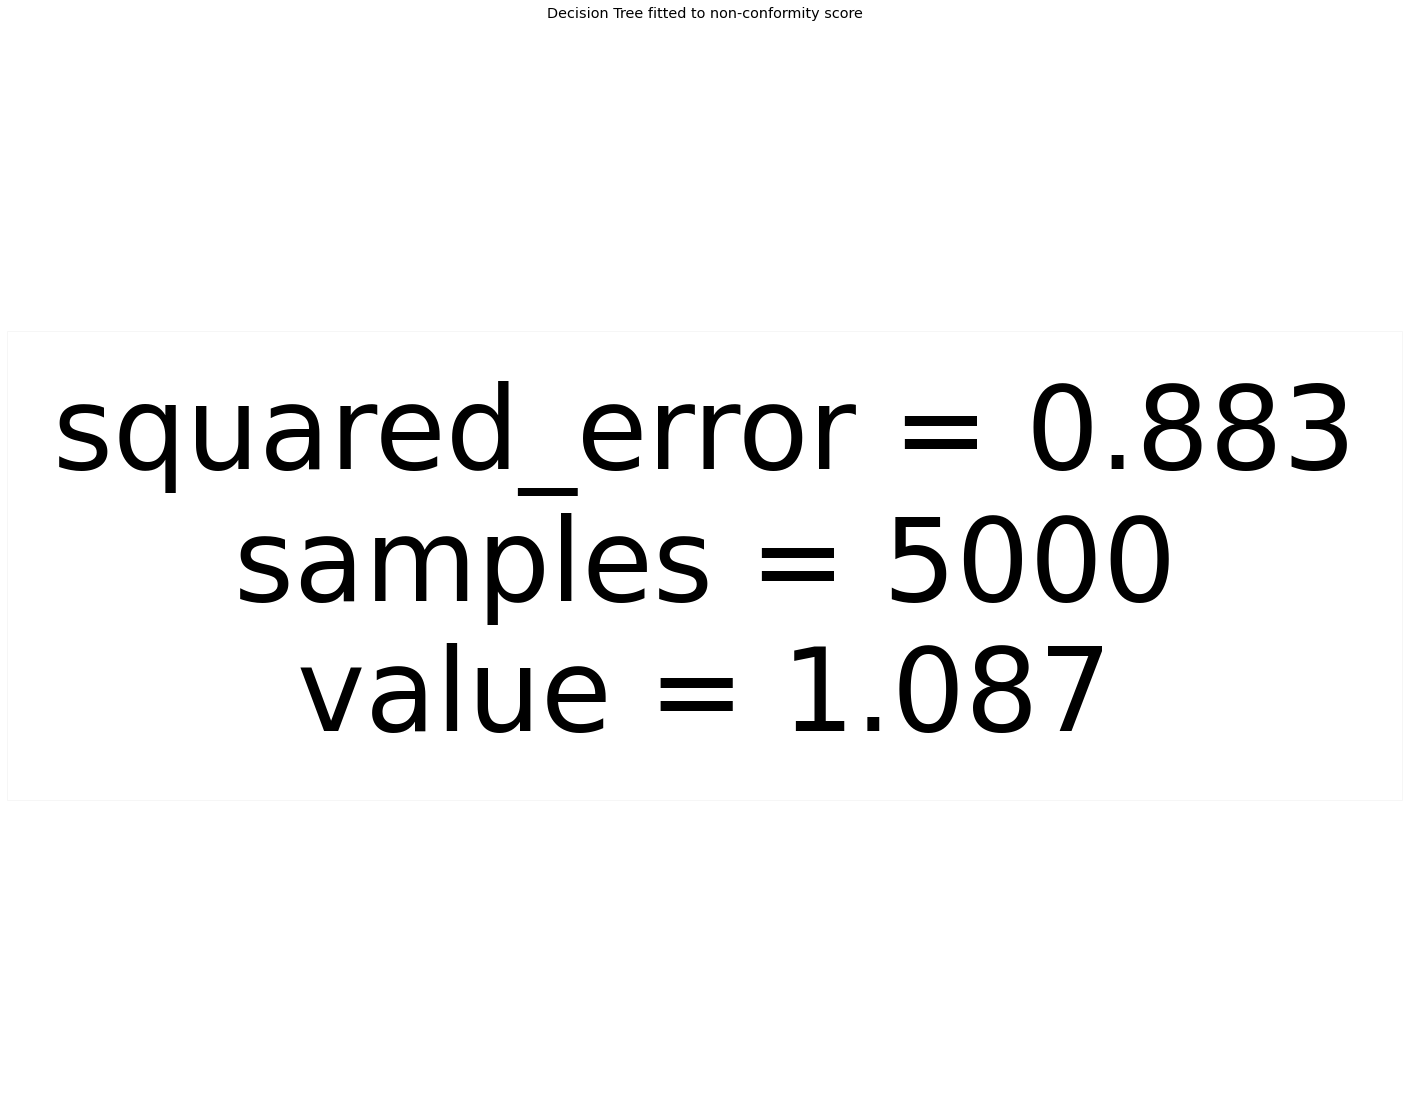

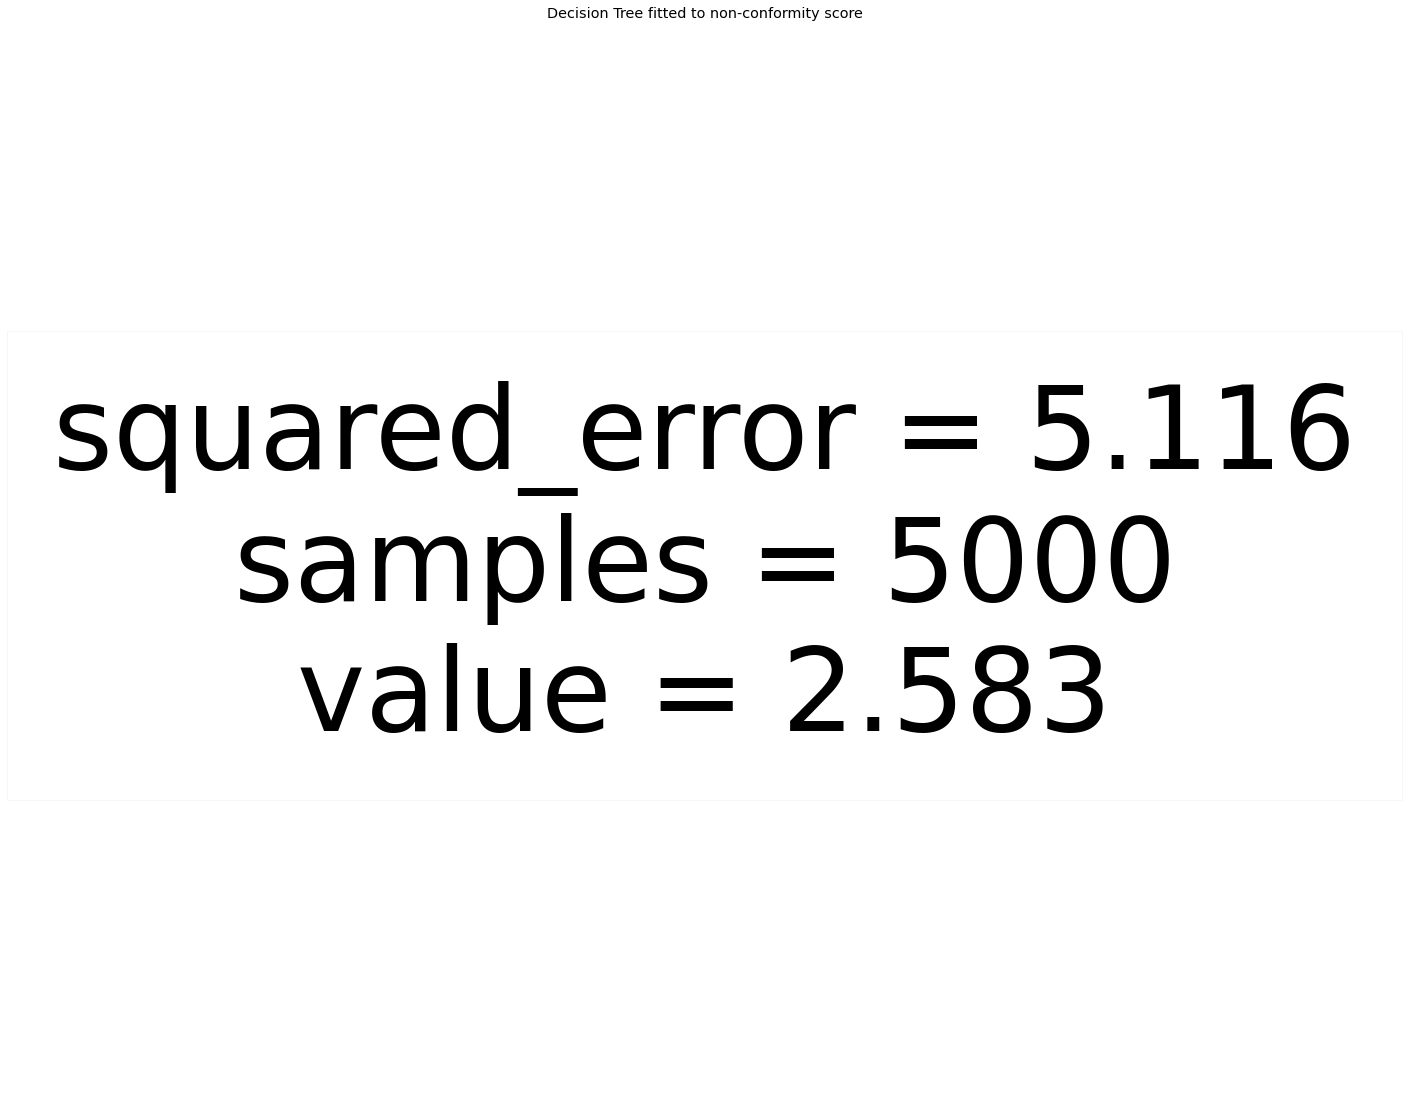

In [7]:
asym_metrics = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, asym_value = 0.6, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True,  m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [8]:
asym_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05392,-6.660768,0.166234,0.8998,4.237911,4.237911,0.050583,0.040,0.662
1,Weighted LOCART,0.04772,-6.576659,0.126744,0.9060,4.264658,4.291527,0.043622,0.037,0.400
2,Regresion split,0.05340,-6.661107,0.141830,0.8978,4.194824,4.194824,0.051259,0.040,0.670
3,Weighted regression split,0.04796,-6.566438,0.106667,0.8990,4.145284,4.173604,0.045452,0.038,0.420
4,Mondrian regression split,0.04548,-6.561430,0.113333,0.8984,4.023438,4.029078,0.045320,0.037,0.520


Fitting locart to toy example:
Time Elapsed to fit Locart:  28.76163387298584
Computing metrics
Time Elapsed to compute metrics for Locart:  1.7870800495147705
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  53.80260467529297
Computing metrics
Time Elapsed to compute metrics for Locart:  1.9777870178222656
Fitting regression split
Time Elapsed to fit regression split:  22.62430167198181
Computing metrics
Time Elapsed to compute statistics for regression split:  1.2425804138183594
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  51.63857340812683
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  51.63857340812683
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  22.869301795959473
Computing metrics
Cutoff points of wlocart: [4.80042497]
Cutoff point of wicp: 4.91897631369611


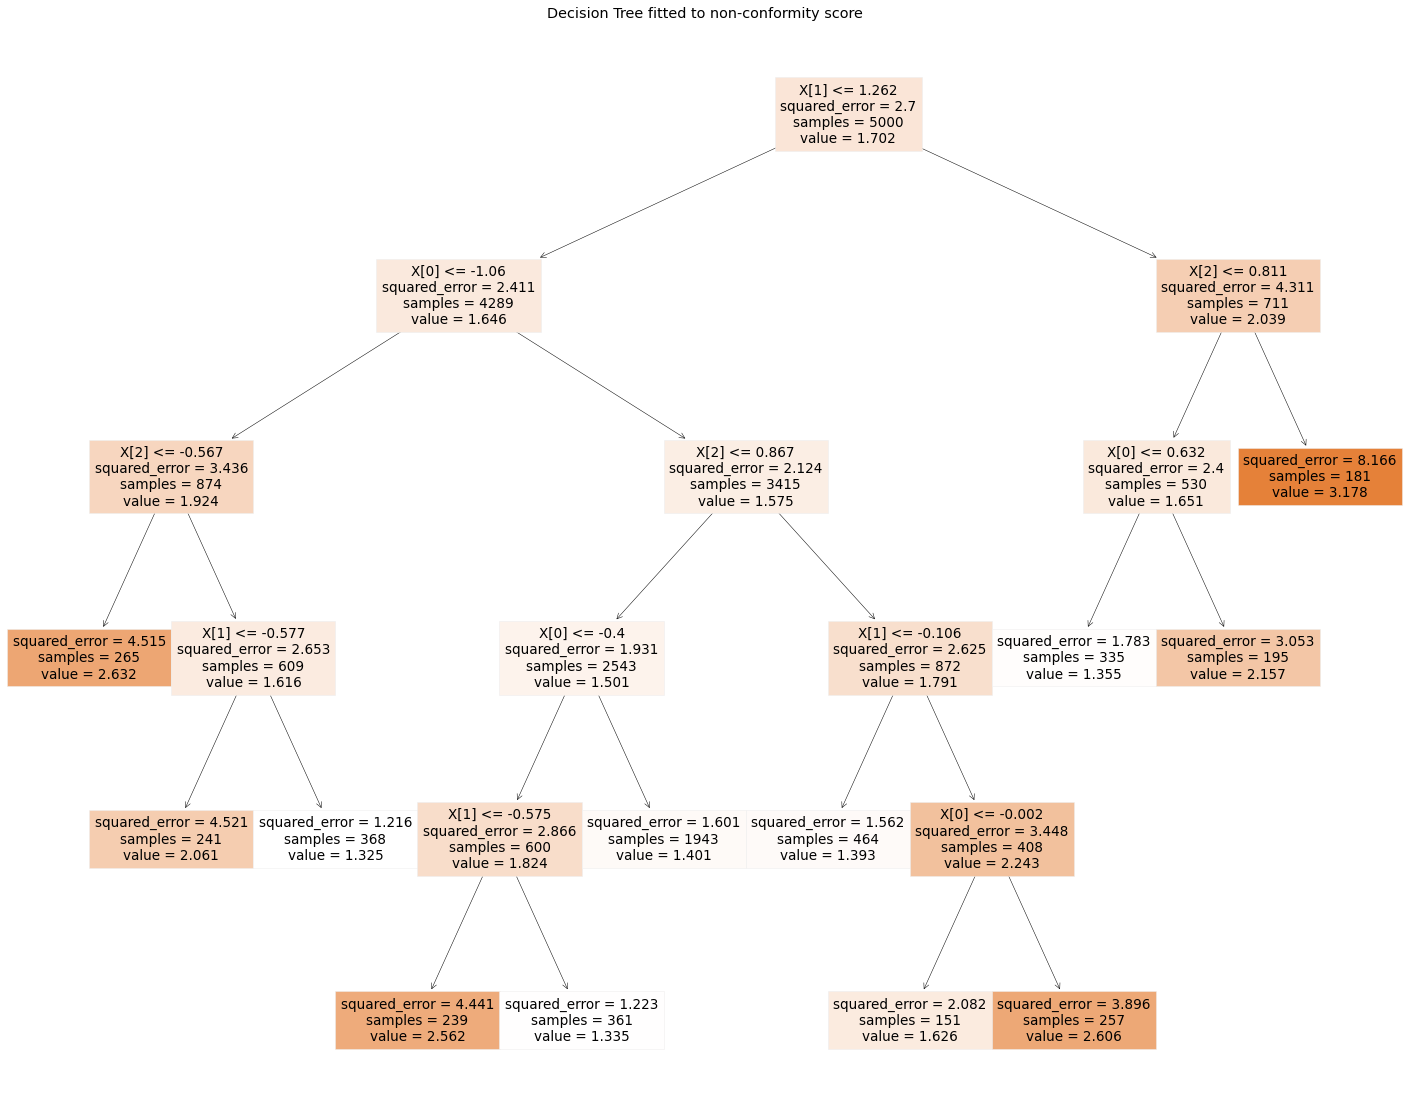

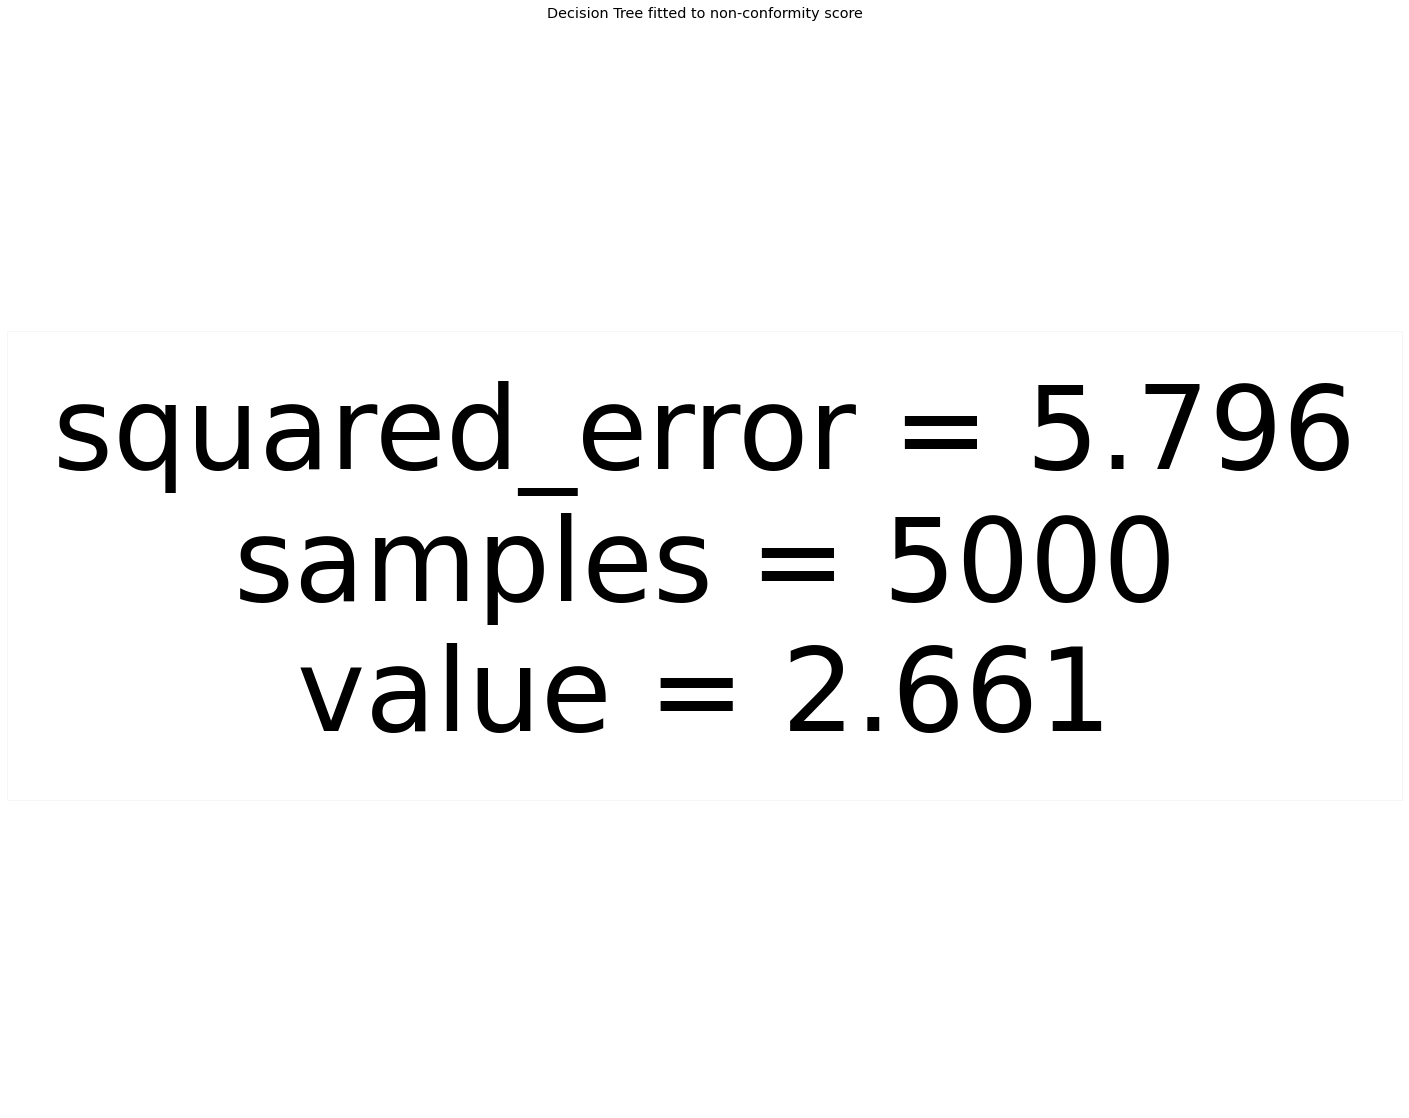

In [9]:
asym_metrics_v2 = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, asym_value = 1.5, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [10]:
asym_metrics_v2

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04992,-10.005061,0.114286,0.8934,6.519888,6.519404,0.069567,0.057,0.766
1,Weighted LOCART,0.04912,-9.684699,0.144444,0.8966,6.295914,6.330520,0.055105,0.047,0.370
2,Regresion split,0.07356,-10.714973,0.197578,0.9036,7.099704,7.099704,0.080460,0.069,0.711
3,Weighted regression split,0.04836,-9.691890,0.145902,0.9026,6.451398,6.483677,0.052930,0.046,0.348
4,Mondrian regression split,0.05012,-9.701641,0.111921,0.8972,6.123849,6.162158,0.056985,0.047,0.391


Fitting locart to toy example:
Time Elapsed to fit Locart:  42.4189190864563
Computing metrics
Time Elapsed to compute metrics for Locart:  1.8948149681091309
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  67.53165769577026
Computing metrics
Time Elapsed to compute metrics for Locart:  2.097107172012329
Fitting regression split
Time Elapsed to fit regression split:  32.546205282211304
Computing metrics
Time Elapsed to compute statistics for regression split:  0.8764441013336182
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  62.187278509140015
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  62.187278509140015
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  32.76859450340271
Computing metrics
Cutoff points of wlocart: [5.54338267]
Cutoff point of wicp: 5.535396329992402


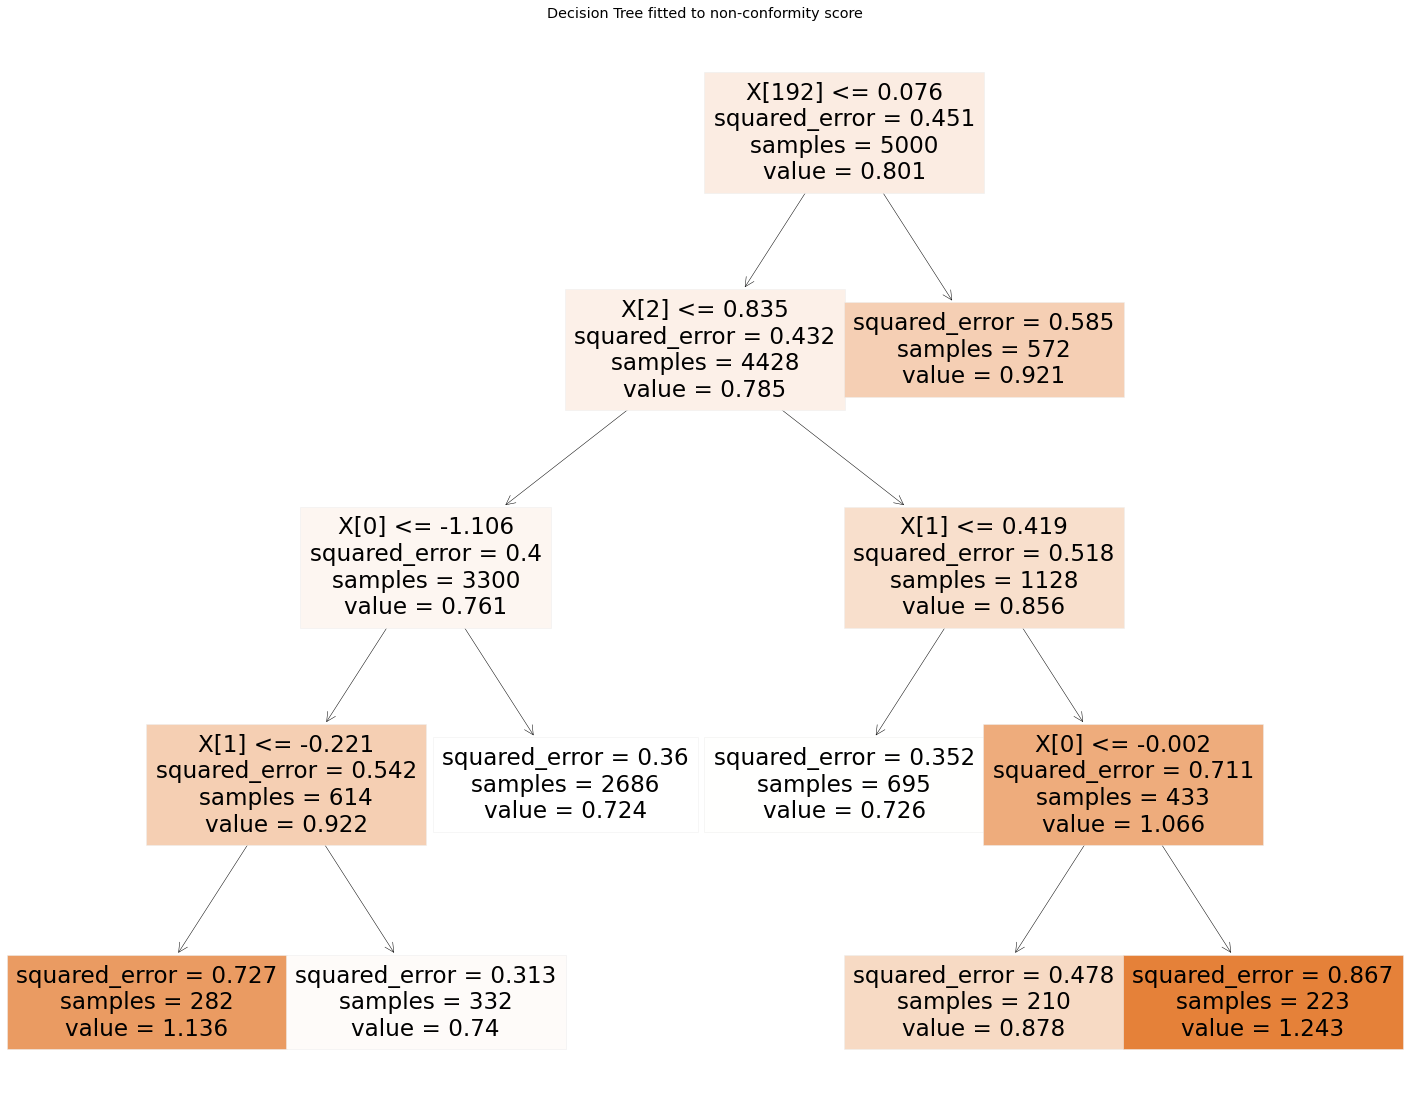

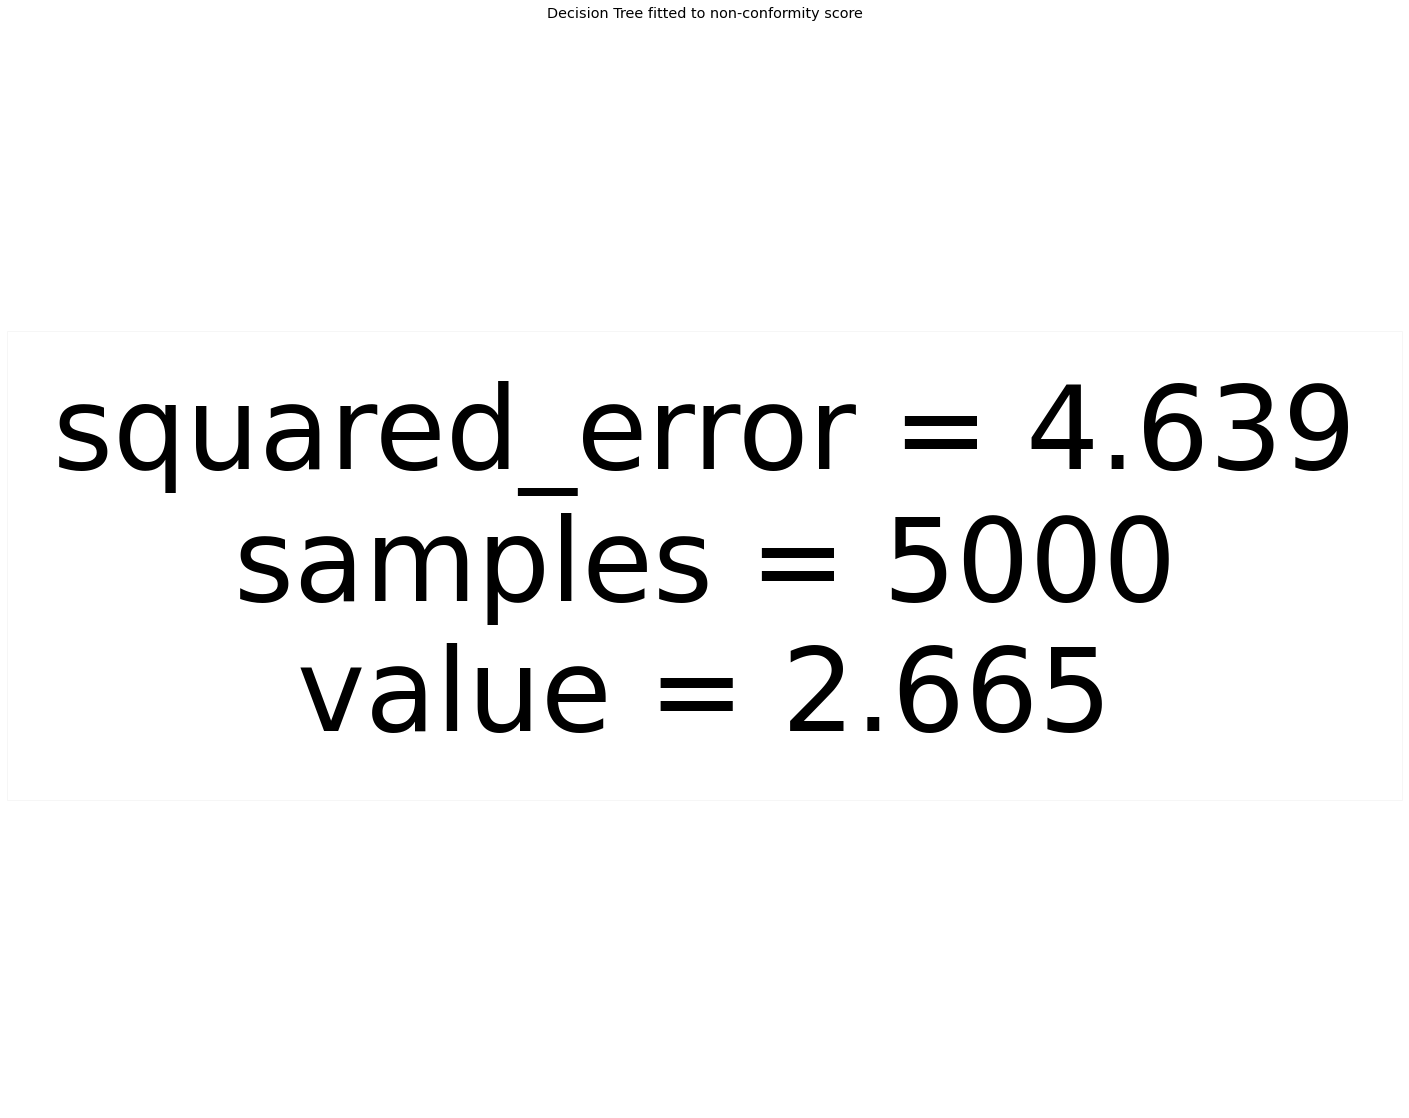

In [11]:
non_cor_heteroc = testing_metrics_sim(kind = "non_cor_heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650,
                                      noise = False, valid_test_size = 0.5, nbins = 30, split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 100)

In [12]:
non_cor_heteroc

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05604,-4.409186,0.206667,0.9014,3.402245,3.404007,0.062810,0.060,0.254
1,Weighted LOCART,0.04708,-4.311280,0.155682,0.9042,3.391303,3.404415,0.051391,0.046,0.243
2,Regresion split,0.06292,-4.477126,0.181106,0.8974,3.390198,3.390198,0.068783,0.067,0.265
3,Weighted regression split,0.04616,-4.310919,0.161628,0.9038,3.386417,3.399150,0.051503,0.046,0.243
4,Mondrian regression split,0.05028,-4.457172,0.120532,0.8998,3.416681,3.427898,0.065414,0.062,0.315


## Changing model to KNN and maintaining number of variables $p$:

Fitting locart to toy example:
Time Elapsed to fit Locart:  19.689209699630737
Computing metrics
Time Elapsed to compute metrics for Locart:  5.369230508804321
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  13.94277286529541
Computing metrics
Time Elapsed to compute metrics for Locart:  9.15253210067749
Fitting regression split
Time Elapsed to fit regression split:  3.254453182220459
Computing metrics
Time Elapsed to compute statistics for regression split:  3.682375431060791
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.718119621276855
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.718119621276855
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  20.083375930786133
Computing metrics
Cutoff points of wlocart: [2.19157276]
Cutoff point of wicp: 2.233610084971219


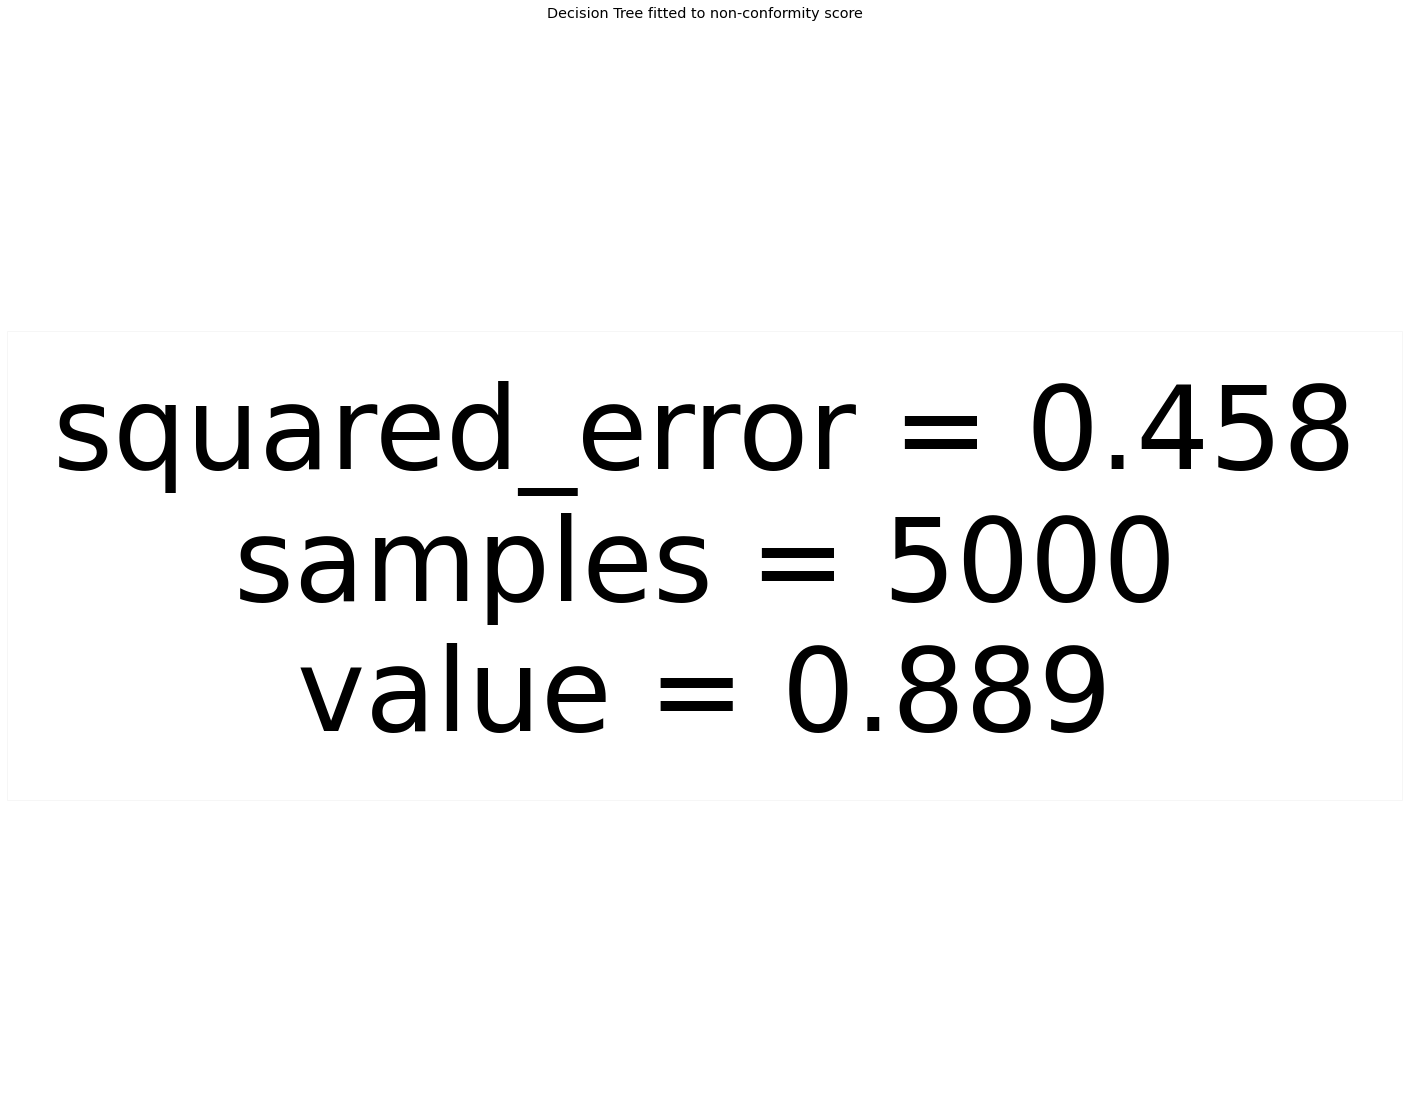

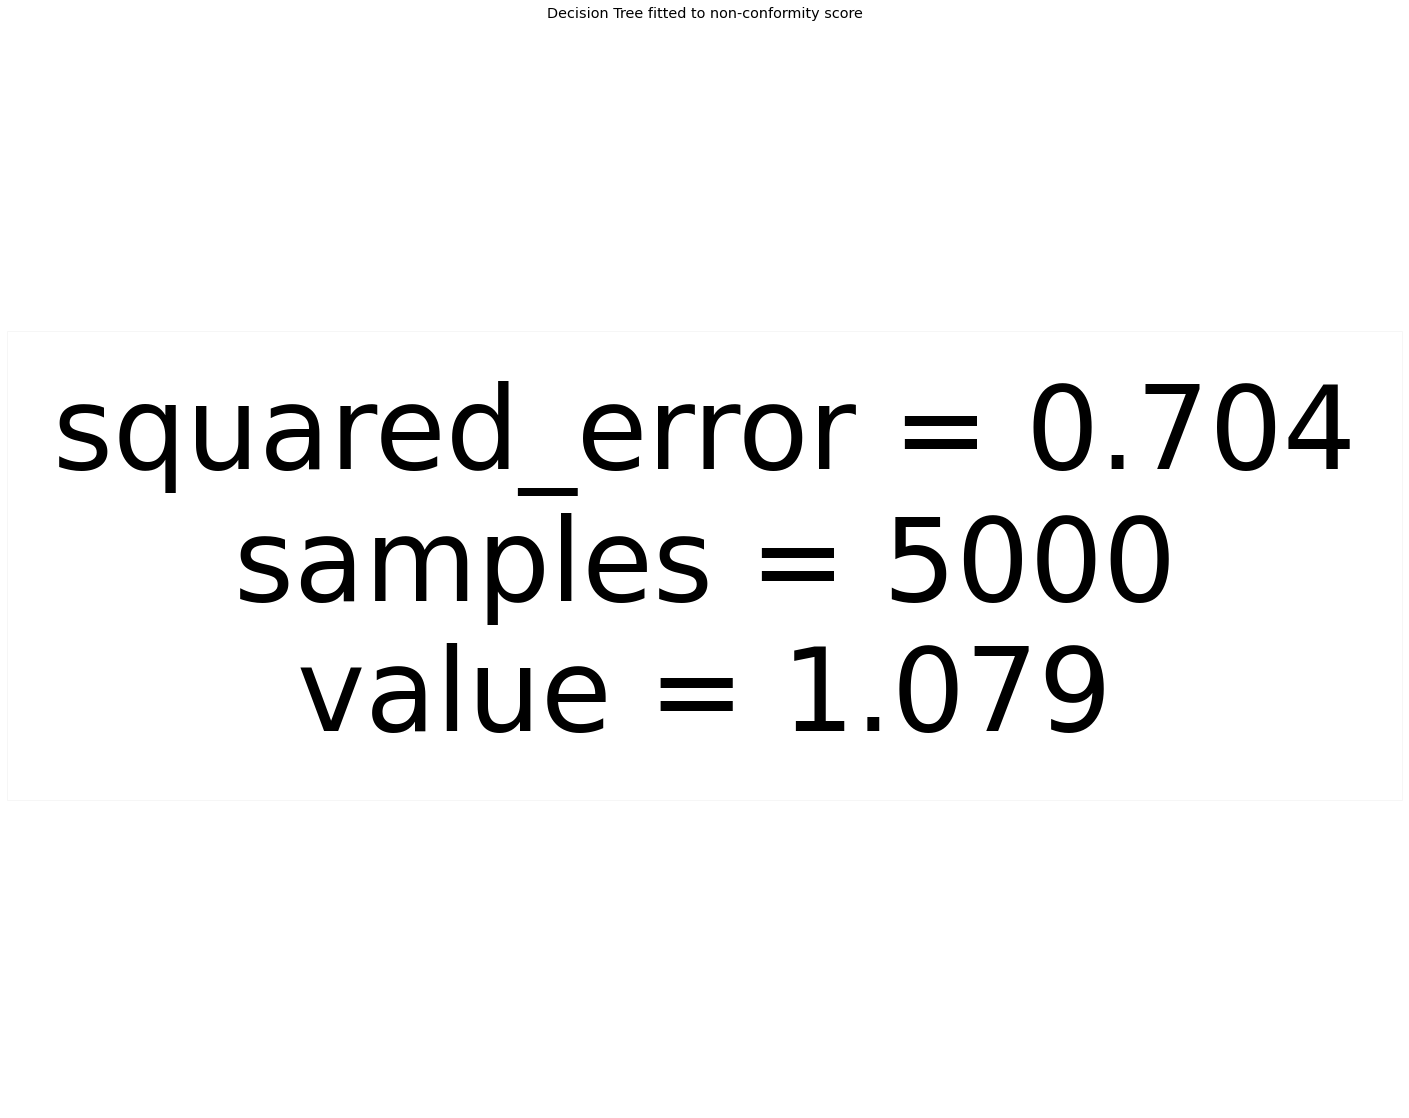

In [13]:
homoc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, n_neighbors = 30, random_seed = 950, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [14]:
homoc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05192,-4.522250,0.138739,0.9038,3.685293,3.685293,0.032953,0.027,0.335
1,Weighted LOCART,0.05100,-4.649125,0.117557,0.8962,3.685550,3.713165,0.048938,0.039,0.468
2,Regresion split,0.05192,-4.522481,0.138739,0.9038,3.691359,3.691359,0.033072,0.028,0.333
3,Weighted regression split,0.04928,-4.653176,0.148731,0.9018,3.756244,3.783794,0.048390,0.040,0.453
4,Mondrian regression split,0.05104,-4.540951,0.120000,0.8998,3.636644,3.641440,0.036561,0.028,0.341


Fitting locart to toy example:
Time Elapsed to fit Locart:  9.098684787750244
Computing metrics
Time Elapsed to compute metrics for Locart:  5.631527900695801
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  14.518782615661621
Computing metrics
Time Elapsed to compute metrics for Locart:  10.395574569702148
Fitting regression split
Time Elapsed to fit regression split:  3.3531155586242676
Computing metrics
Time Elapsed to compute statistics for regression split:  4.31364369392395
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.869263172149658
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.869263172149658
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  19.995317220687866
Computing metrics
Cutoff points of wlocart: [2.31011155]
Cutoff point of wicp: 2.3187401422254146


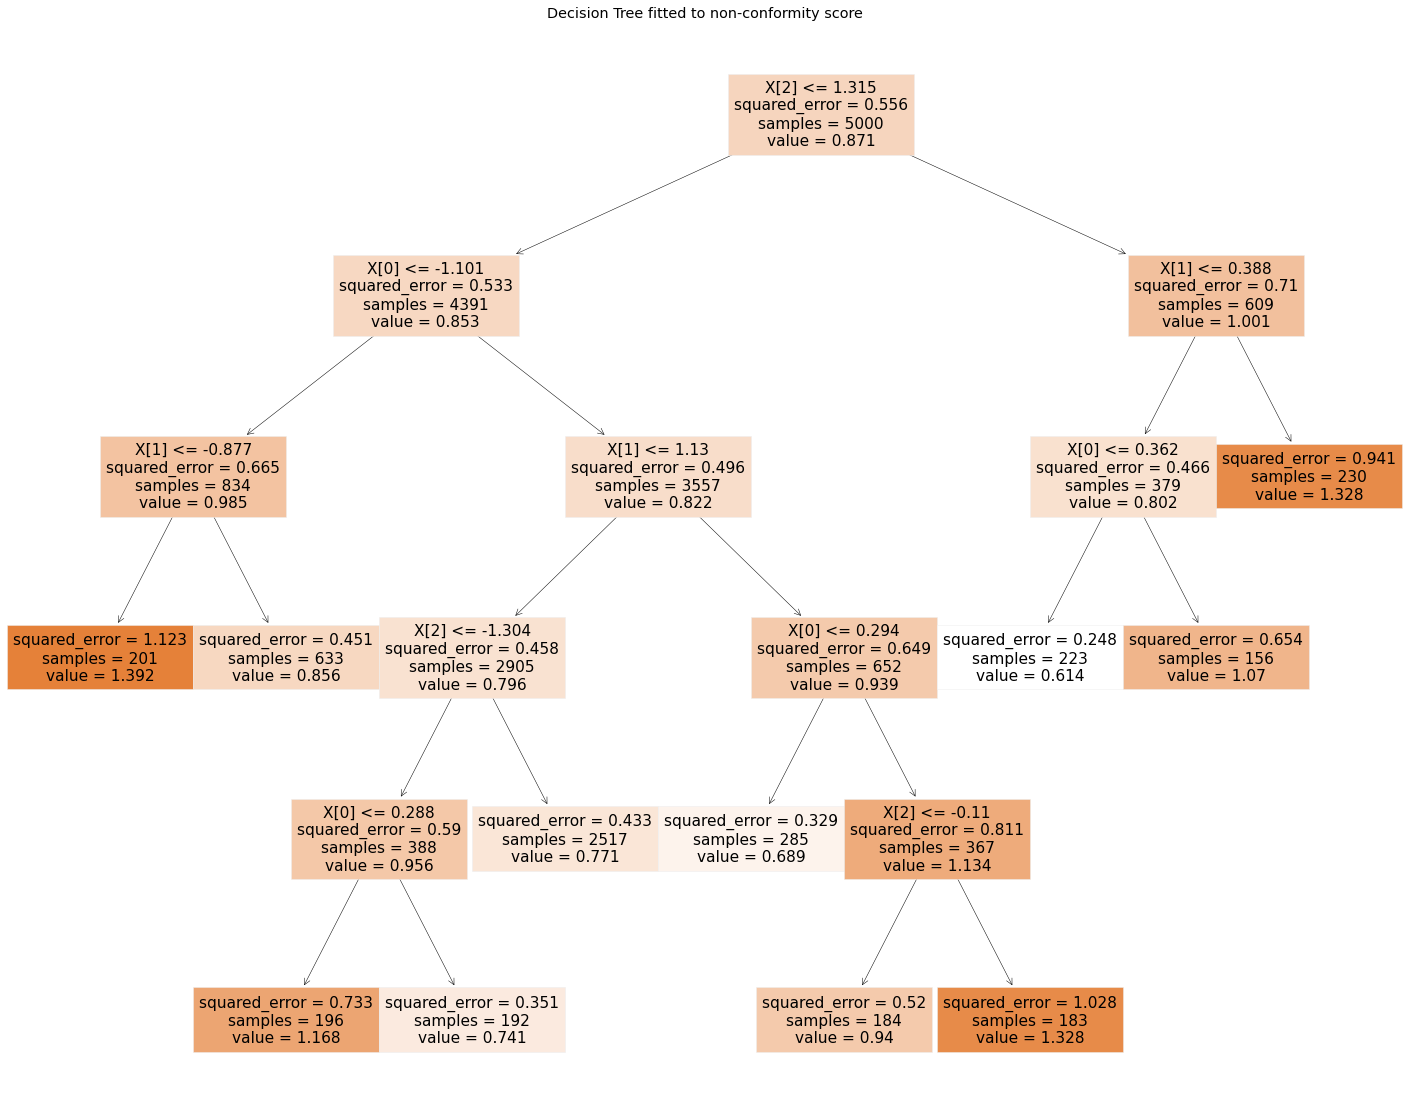

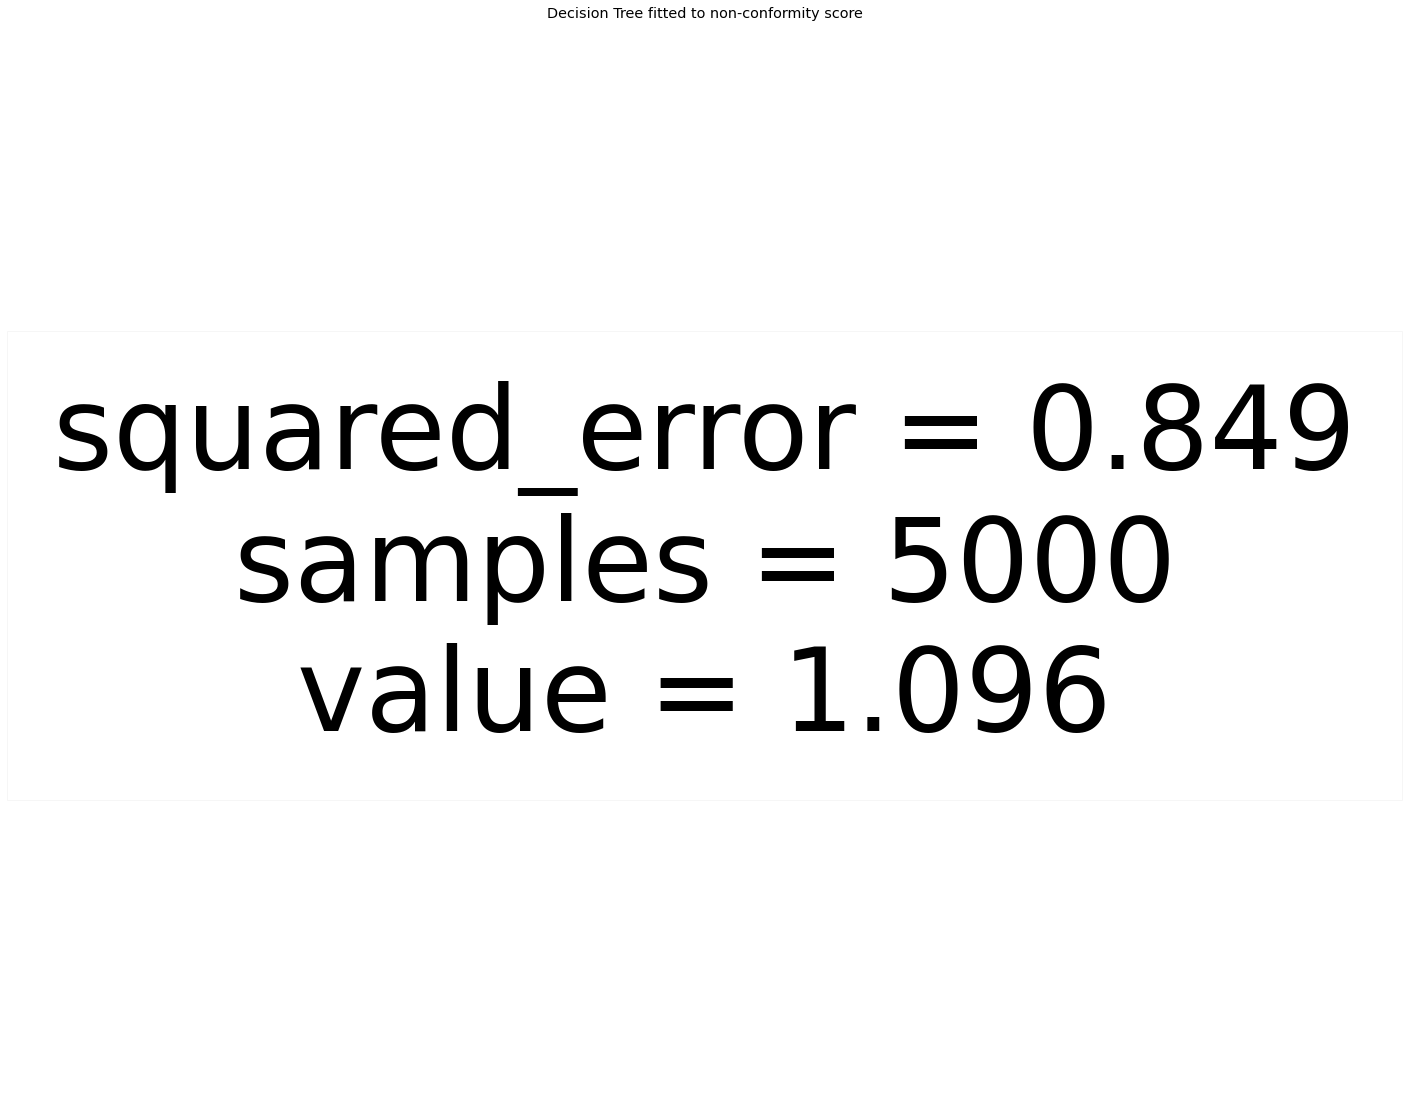

In [15]:
heteroc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "heteroscedastic", n_neighbors = 30, hetero_value = 0.25, random_seed = 950,
                                      valid_test_size=0.5, nbins = 30, noise = False,  split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 150)

In [16]:
heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06820,-4.859357,0.265591,0.8870,3.596813,3.597350,0.071681,0.067,0.365
1,Weighted LOCART,0.05392,-4.903478,0.181437,0.8964,3.719327,3.730428,0.072467,0.067,0.403
2,Regresion split,0.07312,-4.966281,0.281910,0.9000,3.730715,3.730715,0.077942,0.075,0.393
3,Weighted regression split,0.05536,-4.903441,0.181437,0.8974,3.733219,3.744298,0.072194,0.067,0.399
4,Mondrian regression split,0.05396,-4.656295,0.140000,0.8886,3.522612,3.531040,0.055230,0.046,0.335


Fitting locart to toy example:
Time Elapsed to fit Locart:  12.246329545974731
Computing metrics
Time Elapsed to compute metrics for Locart:  5.7427544593811035
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  17.819116830825806
Computing metrics
Time Elapsed to compute metrics for Locart:  10.409858226776123
Fitting regression split
Time Elapsed to fit regression split:  3.152486801147461
Computing metrics
Time Elapsed to compute statistics for regression split:  5.10970139503479
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.66550588607788
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.66550588607788
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  30.449854373931885
Computing metrics
Cutoff points of wlocart: [2.05079679]
Cutoff point of wicp: 2.0299569477458355


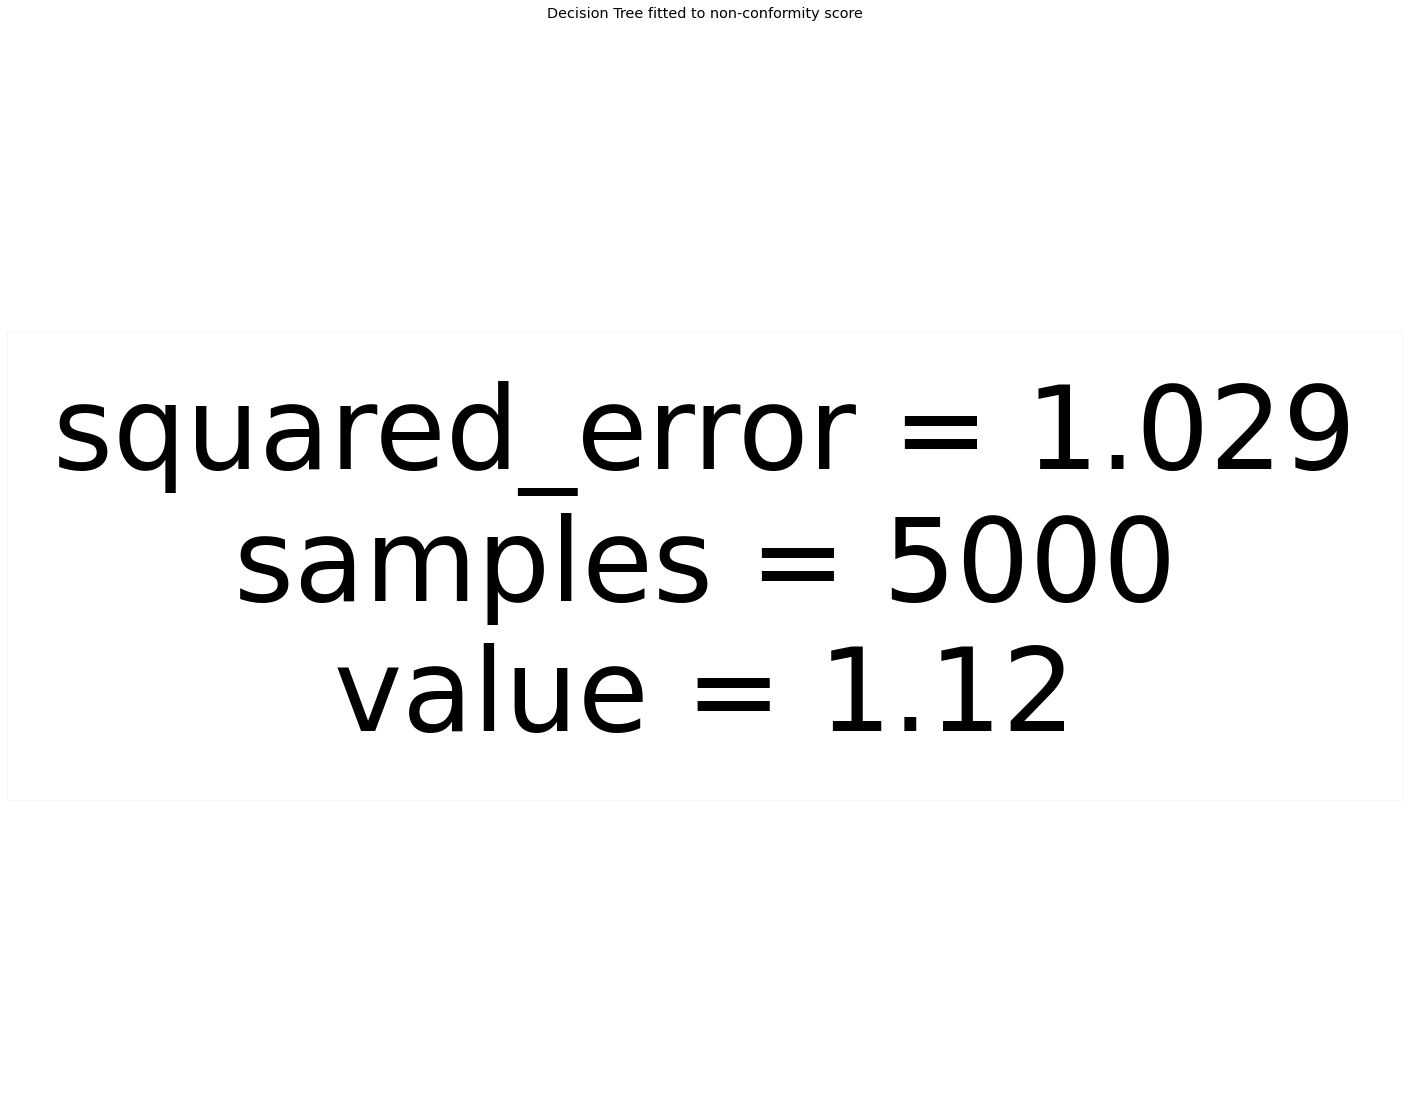

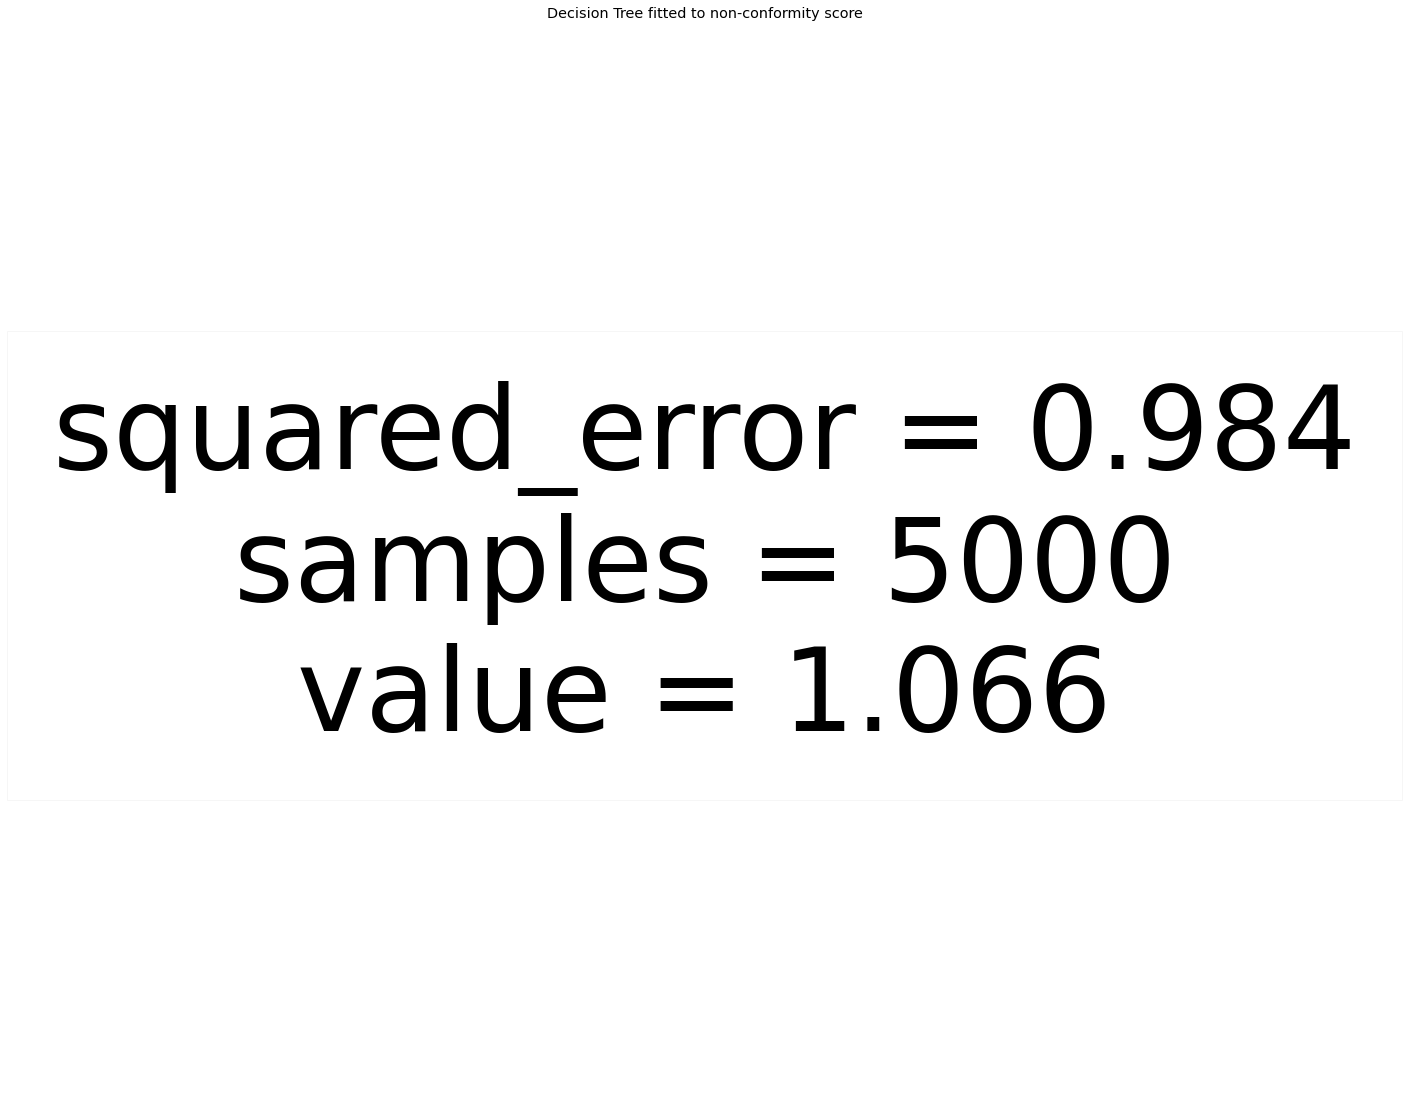

In [17]:
asym_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "asymmetric", n_neighbors = 30, asym_value = 0.6, random_seed = 950, 
                                   valid_test_size=0.5, nbins = 30, noise = False, split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                   valid_min_sample = 150, min_samples_leaf = 150)

In [18]:
asym_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06352,-7.242055,0.255263,0.8990,4.404342,4.404342,0.057448,0.049,0.421
1,Weighted LOCART,0.05624,-7.286458,0.212500,0.8938,4.376214,4.397031,0.055761,0.047,0.498
2,Regresion split,0.06080,-7.244004,0.268421,0.8946,4.330983,4.330983,0.058208,0.049,0.431
3,Weighted regression split,0.05684,-7.287492,0.212500,0.8924,4.331743,4.353254,0.056174,0.046,0.502
4,Mondrian regression split,0.05472,-7.108407,0.192398,0.8926,4.353831,4.355966,0.055379,0.045,0.490


Fitting locart to toy example:
Time Elapsed to fit Locart:  10.157236337661743
Computing metrics
Time Elapsed to compute metrics for Locart:  5.533715009689331
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  16.299165964126587
Computing metrics
Time Elapsed to compute metrics for Locart:  10.37571930885315
Fitting regression split
Time Elapsed to fit regression split:  3.265188694000244
Computing metrics
Time Elapsed to compute statistics for regression split:  4.325334548950195
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.542606592178345
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.542606592178345
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  27.820106029510498
Computing metrics
Cutoff points of wlocart: [1.92221087]
Cutoff point of wicp: 2.0057850824692247


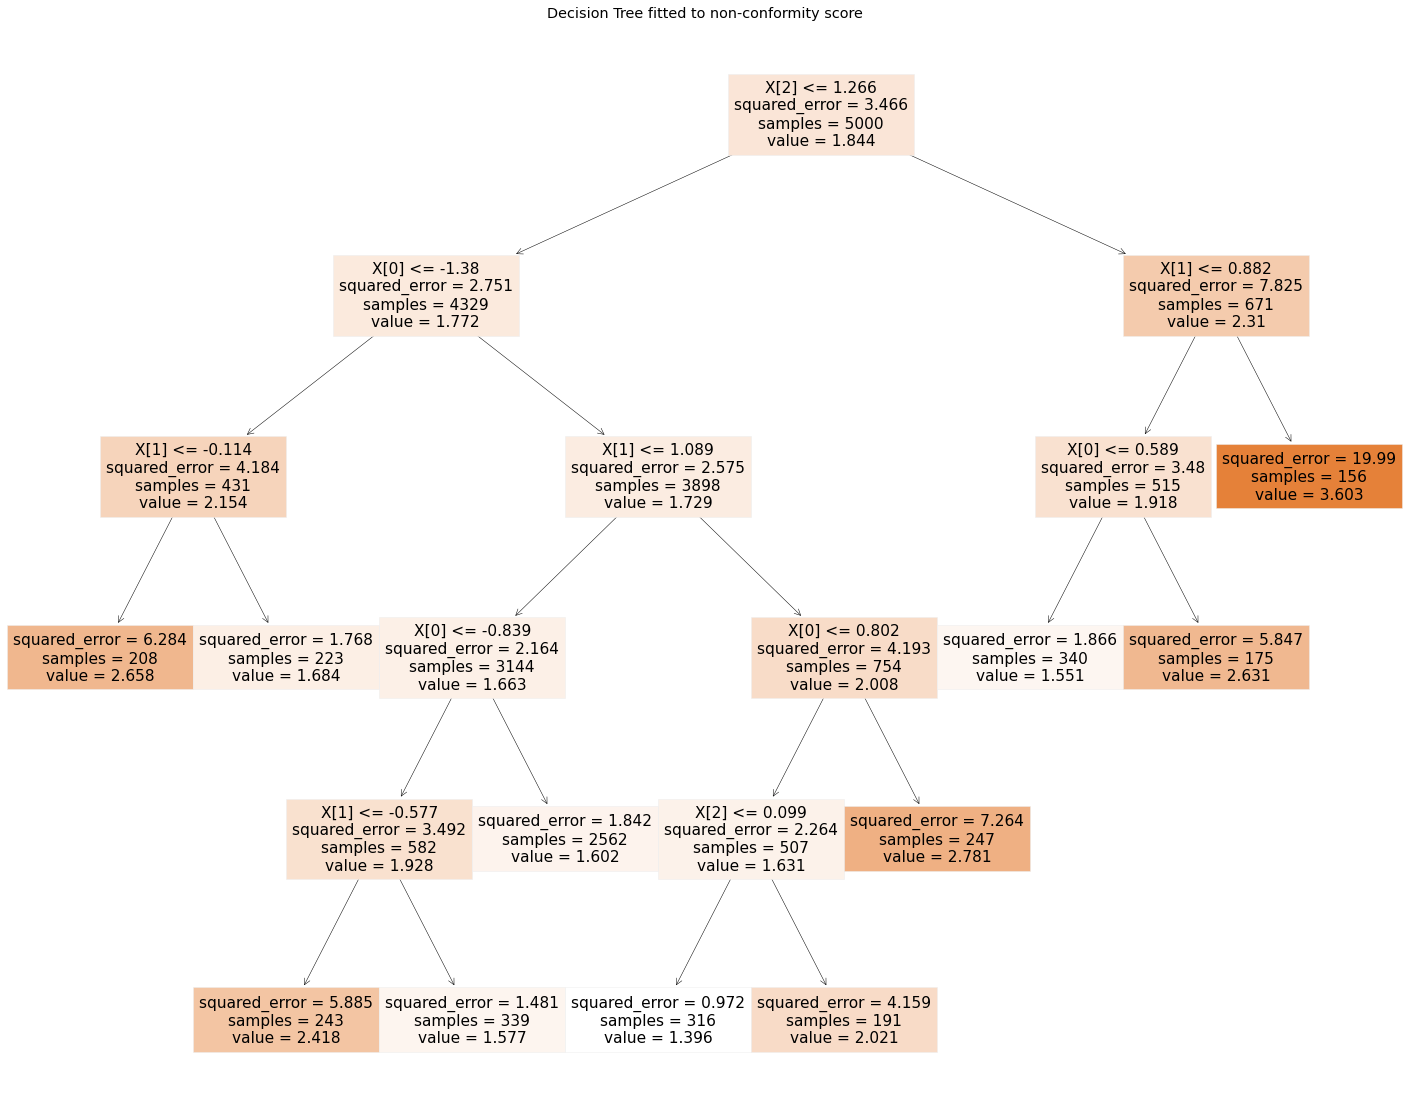

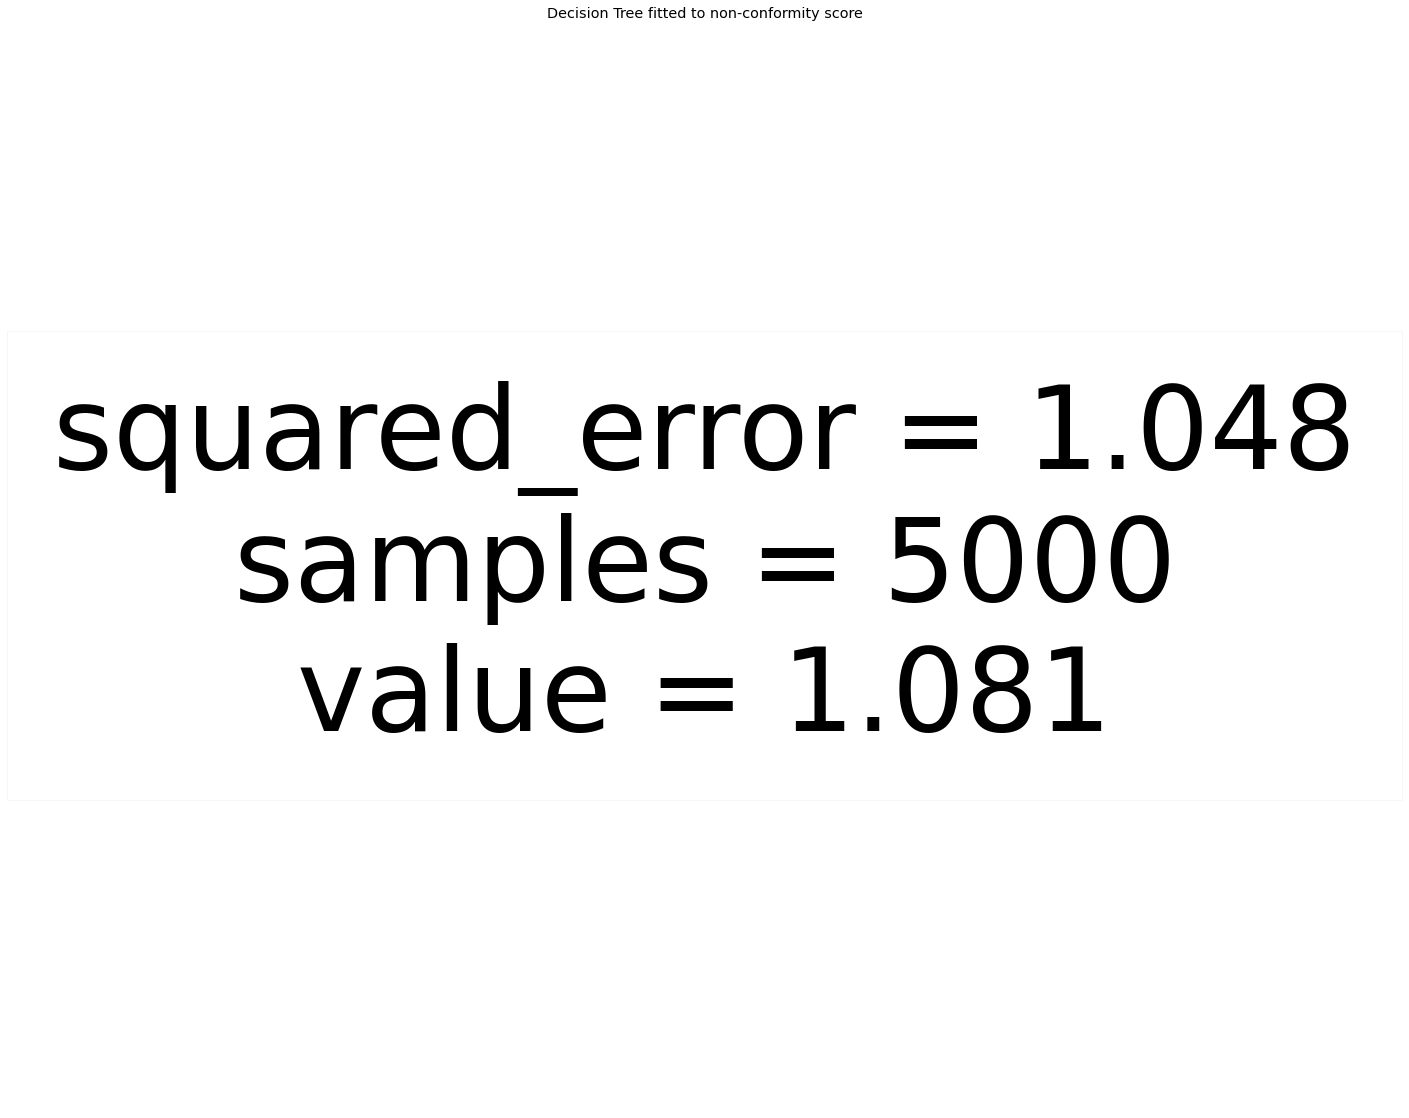

In [19]:
asym_v2_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "asymmetric", n_neighbors = 30, asym_value = 1.5, random_seed = 950,
                                      valid_test_size=0.5, nbins = 30, noise = False, split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 150)

In [20]:
asym_v2_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06124,-11.295610,0.222097,0.8946,7.117271,7.139080,0.078047,0.069,0.654
1,Weighted LOCART,0.07572,-11.804936,0.259589,0.8920,6.568823,6.564253,0.081798,0.070,0.607
2,Regresion split,0.07864,-12.121243,0.425773,0.9030,7.033948,7.033948,0.086504,0.078,0.578
3,Weighted regression split,0.07352,-11.792740,0.251916,0.9002,6.854424,6.849438,0.079327,0.071,0.596
4,Mondrian regression split,0.05544,-10.833043,0.136287,0.8956,7.168416,7.176982,0.069254,0.058,0.578


Fitting locart to toy example:
Time Elapsed to fit Locart:  8.43742847442627
Computing metrics
Time Elapsed to compute metrics for Locart:  5.808401107788086
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  15.420174598693848
Computing metrics
Time Elapsed to compute metrics for Locart:  9.795548677444458
Fitting regression split
Time Elapsed to fit regression split:  3.2425026893615723
Computing metrics
Time Elapsed to compute statistics for regression split:  5.236151456832886
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  8.608797311782837
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  8.608797311782837
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  37.41462302207947
Computing metrics
Cutoff points of wlocart: [2.29940216]
Cutoff point of wicp: 2.2791154569877263


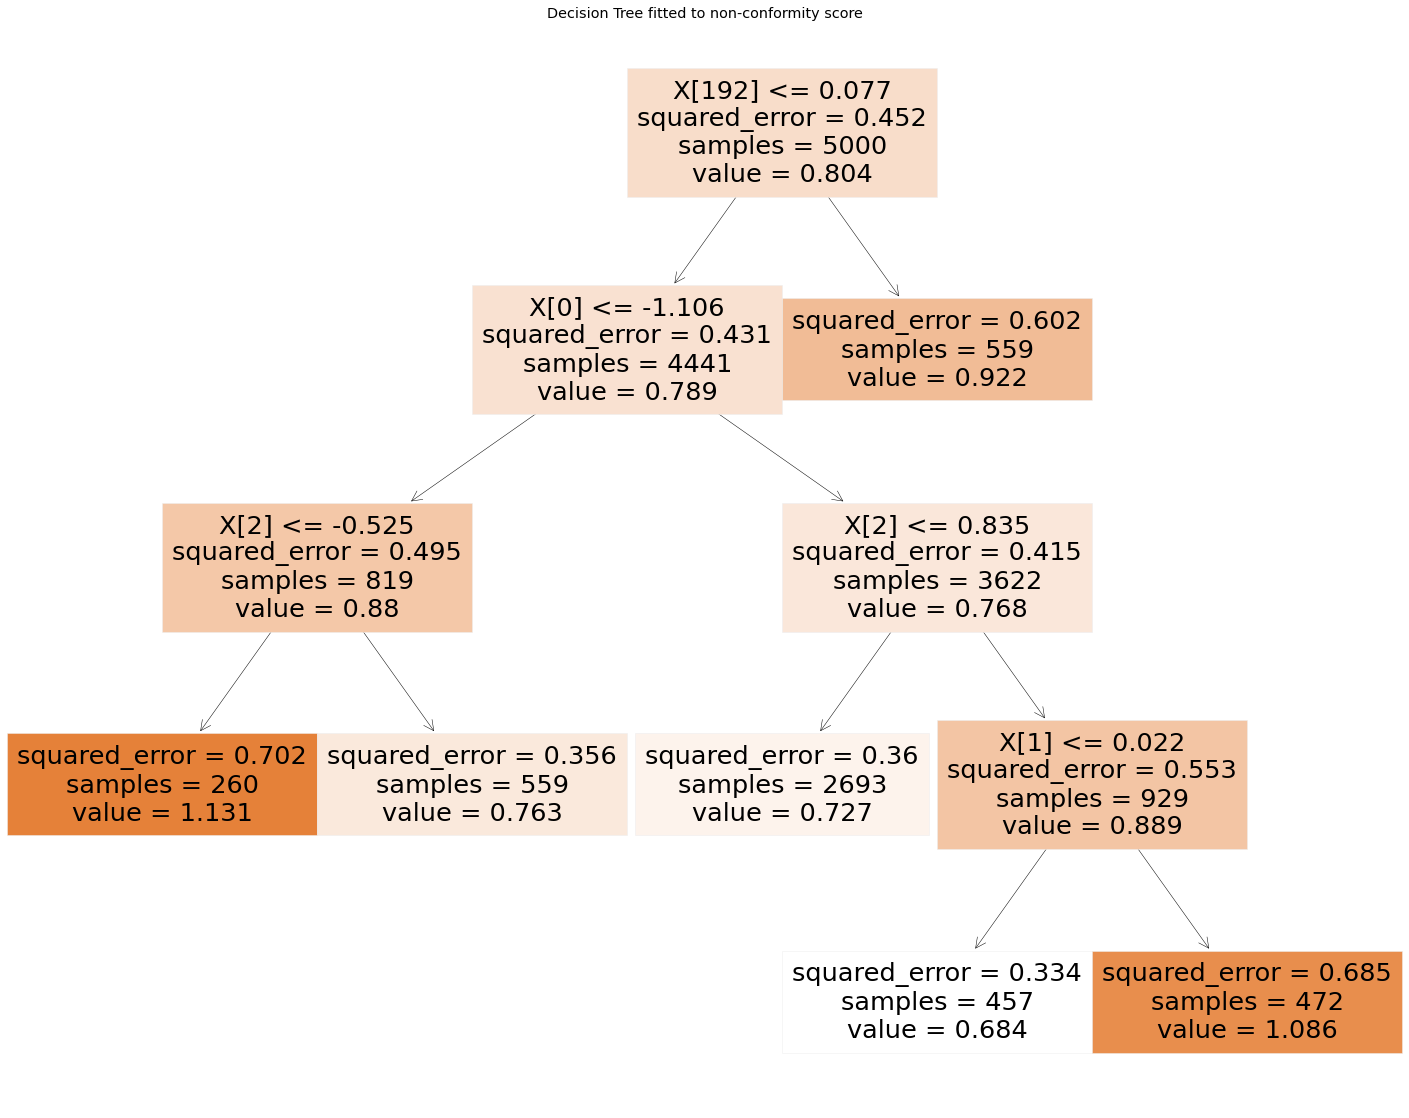

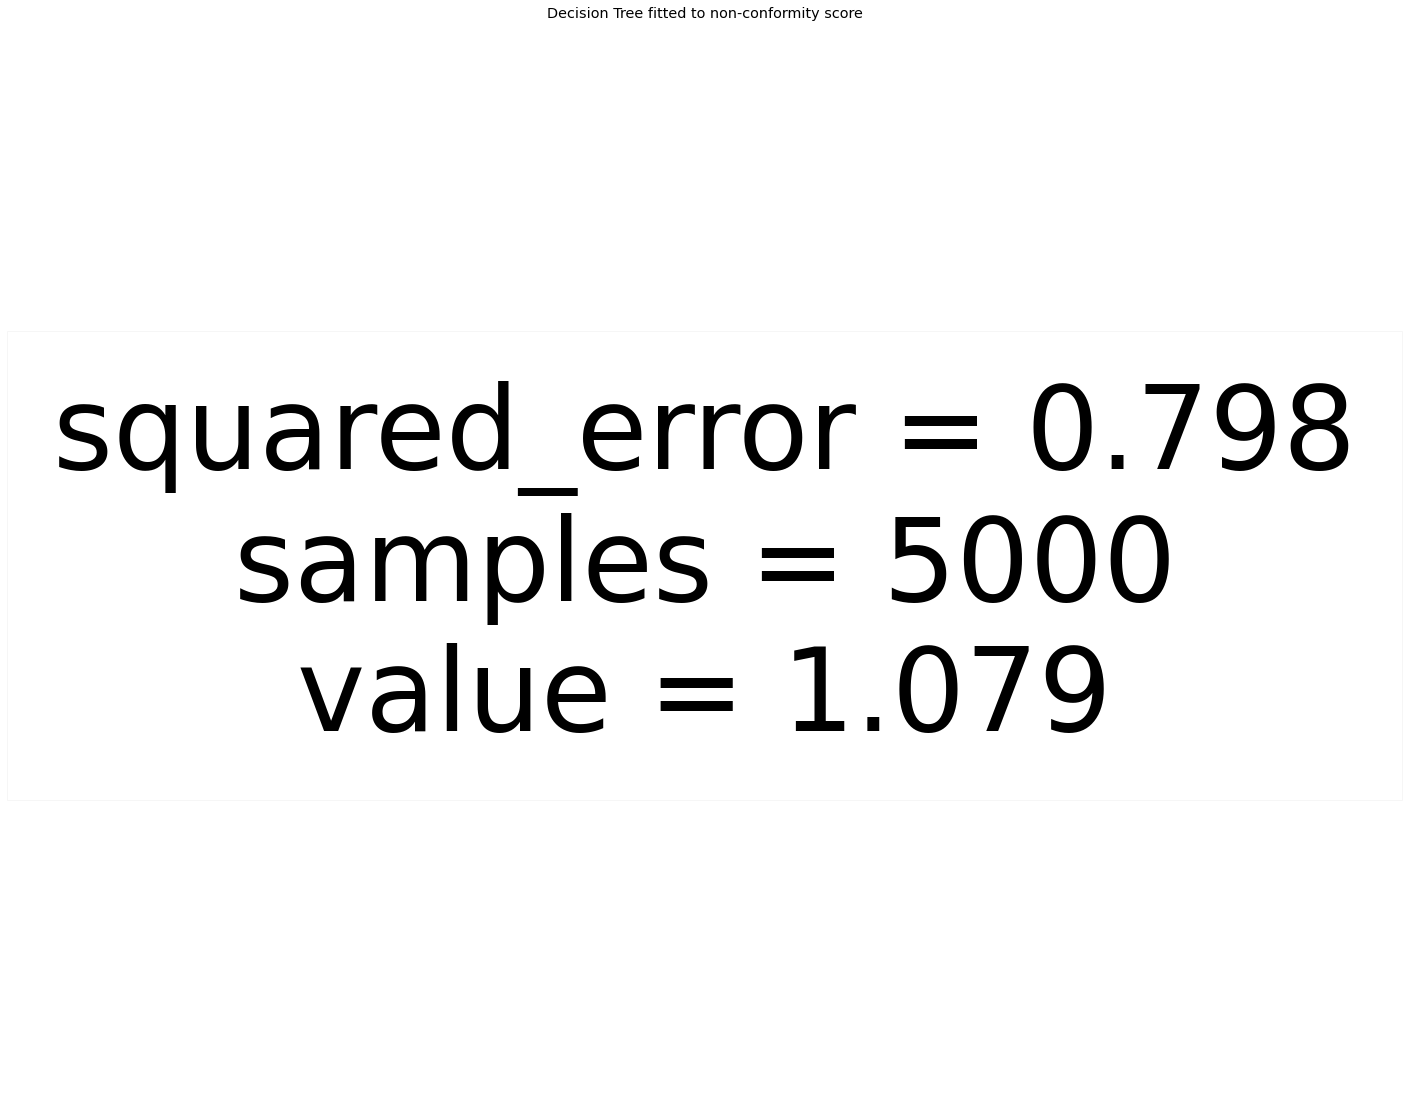

In [21]:
non_corr_heteroc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "non_cor_heteroscedastic", hetero_value = 0.25, n_neighbors = 30, random_seed = 950,
                                               valid_test_size=0.5, nbins = 30, noise = False,  split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                               valid_min_sample = 150, min_samples_leaf = 150)

In [22]:
non_corr_heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05792,-4.453030,0.206667,0.8950,3.385603,3.386165,0.063983,0.061,0.255
1,Weighted LOCART,0.05032,-4.473529,0.125166,0.9002,3.477926,3.490283,0.061227,0.058,0.307
2,Regresion split,0.05616,-4.518353,0.169231,0.8932,3.391125,3.391125,0.068880,0.067,0.254
3,Weighted regression split,0.04760,-4.472771,0.120126,0.8984,3.447241,3.459245,0.061877,0.057,0.312
4,Mondrian regression split,0.05220,-4.522613,0.151366,0.8902,3.315002,3.328665,0.068344,0.065,0.278
